# Analyse der Gesamttabelle

In [1]:
# Import der notwendigen Bibliotheken
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Konfiguration
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

stores = pd.read_csv("data/stores.csv")
products = pd.read_csv("data/products.csv")
transactions = pd.read_parquet("data/transactions_train_1.parquet")
transaction_lines = pd.read_parquet("data/transaction_lines_train_1.parquet")

## Join

In [2]:
# ID-Spallten für Join umbenennen
stores.rename(columns={"id": "store_id"}, inplace=True)
products.rename(columns={"id": "product_id"}, inplace=True)
transactions.rename(columns={"id": "transaction_id"}, inplace=True)

# Transaction-Tabelle mit Store-Tabelle  joinen
joined_transactions = transactions.merge(stores, on="store_id", how="left")

# Transaction_lines-Tabelle mit Product-Tabelle joinen
joined_transactionlines = transaction_lines.merge(products, on="product_id", how="left")

## Tabelle joined_transactions

In [3]:
# Datentypen ansehen
joined_transactions.dtypes

transaction_id               object
store_id                     object
cash_desk                     int64
transaction_start    datetime64[us]
transaction_end      datetime64[us]
total_amount                float64
n_lines                       int64
payment_medium               object
customer_feedback           float64
damage                      float64
label                        object
opening_date                 object
location                     object
state                        object
urbanization                 object
sco_introduction             object
dtype: object

In [4]:
joined_transactions.shape

(1558245, 16)

In [5]:
# Tabelle ansehen
joined_transactions.head(3)

,transaction_id,store_id,cash_desk,transaction_start,transaction_end,total_amount,n_lines,payment_medium,customer_feedback,damage,label,opening_date,location,state,urbanization,sco_introduction
0,5bedf771-f016-41a7-ab89-f40e7f6be955,b0973ffa-ce15-41e0-9de7-1390598e24f2,0,2022-02-02 08:00:12,2022-02-02 08:01:02.825563,52.26,6,CREDIT_CARD,NaN,NaN,UNKNOWN,2005-06-02,Berlin,Berlin,RURAL,2022-02-02
1,21ff1406-dbc4-41a7-8429-836cbf96d853,b0973ffa-ce15-41e0-9de7-1390598e24f2,1,2022-02-02 08:05:06,2022-02-02 08:05:30.565876,1.47,1,CREDIT_CARD,NaN,NaN,UNKNOWN,2005-06-02,Berlin,Berlin,RURAL,2022-02-02
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,b0973ffa-ce15-41e0-9de7-1390598e24f2,2,2022-02-02 08:07:12,2022-02-02 08:11:29.434607,363.87,37,CREDIT_CARD,NaN,0.0,NORMAL,2005-06-02,Berlin,Berlin,RURAL,2022-02-02


Löschen der Spalten 'opening_date' und 'sco_introduction' aufgrund Irrelevanz

In [6]:
joined_transactions.drop(columns=['opening_date', 'sco_introduction'], inplace=True)

Spalten mit fehlenden Werten

In [7]:
missing_values = joined_transactions.isnull().sum()
print(missing_values)

transaction_id             0
store_id                   0
cash_desk                  0
transaction_start          0
transaction_end            0
total_amount               0
n_lines                    0
payment_medium             0
customer_feedback    1449915
damage               1402553
label                      0
location                   0
state                      0
urbanization               0
dtype: int64


--> 'customer_Feedback' hat rund 96% und 'damage' rund 93% fehlende Werte. 

'customer_feedback'

In [8]:
# Absolute Häufigkeit (inkl. NaN)
feedback_counts = joined_transactions['customer_feedback'].value_counts(dropna=False)

# Prozentuale Verteilung
feedback_percent = joined_transactions['customer_feedback'].value_counts(normalize=True, dropna=False) * 100

# Kombinieren in DataFrame
feedback_summary = pd.DataFrame({
    'Anzahl': feedback_counts,
    'Prozent': feedback_percent.round(2)
})

print(feedback_summary)

                    Anzahl  Prozent
customer_feedback                  
NaN                1449915    93.05
10.0                 83637     5.37
9.0                   5431     0.35
8.0                   4473     0.29
7.0                   3714     0.24
6.0                   2816     0.18
1.0                   2516     0.16
5.0                   2126     0.14
4.0                   1620     0.10
3.0                   1086     0.07
2.0                    911     0.06


In [9]:
# Korrelation zum Label prüfen
pd.crosstab(joined_transactions['customer_feedback'], joined_transactions['label'], normalize='index') * 100

label,FRAUD,NORMAL,UNKNOWN
customer_feedback,,,
1.0,0.198728,9.379968,90.421304
2.0,0.000000,9.110867,90.889133
3.0,0.276243,10.773481,88.950276
4.0,0.000000,8.888889,91.111111
5.0,0.235183,9.689558,90.075259
6.0,0.106534,9.943182,89.950284
7.0,0.107701,9.962305,89.929995
8.0,0.089425,10.283926,89.626649
9.0,0.110477,9.206408,90.683115


In [10]:
pd.crosstab(joined_transactions['customer_feedback'], joined_transactions['label'])


label,FRAUD,NORMAL,UNKNOWN
customer_feedback,,,
1.0,5,236,2275
2.0,0,83,828
3.0,3,117,966
4.0,0,144,1476
5.0,5,206,1915
6.0,3,280,2533
7.0,4,370,3340
8.0,4,460,4009
9.0,6,500,4925


Doppelte Zeilen und IDs

In [11]:
# Prüft, ob vollständige Duplikate (identische Zeilen) existieren
duplicate_rows = joined_transactions[joined_transactions.duplicated()]
print(f"Anzahl vollständig doppelter Zeilen: {len(duplicate_rows)}")


Anzahl vollständig doppelter Zeilen: 0


In [12]:
# Prüft, ob die transaction_id mehrfach vorkommt
duplicate_ids = joined_transactions['transaction_id'].duplicated().sum()
print(f"Anzahl mehrfach vorkommender transaction_ids: {duplicate_ids}")

Anzahl mehrfach vorkommender transaction_ids: 0


### Explorative Datenanalyse

In [4]:
# Entferne Zeilen mit label == "UNKNOWN"
joined_transactions = joined_transactions[joined_transactions['label'].isin(['NORMAL', 'FRAUD'])].copy()

In [14]:
# --- Basisübersicht ---
print("\nDatenübersicht:")
print(joined_transactions.info())
print("\nStatistische Beschreibung:")
print(joined_transactions.describe(include='all'))


Datenübersicht:
<class 'pandas.core.frame.DataFrame'>
Index: 155692 entries, 2 to 1558199
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   transaction_id     155692 non-null  object        
 1   store_id           155692 non-null  object        
 2   cash_desk          155692 non-null  int64         
 3   transaction_start  155692 non-null  datetime64[us]
 4   transaction_end    155692 non-null  datetime64[us]
 5   total_amount       155692 non-null  float64       
 6   n_lines            155692 non-null  int64         
 7   payment_medium     155692 non-null  object        
 8   customer_feedback  10641 non-null   float64       
 9   damage             155692 non-null  float64       
 10  label              155692 non-null  object        
 11  location           155692 non-null  object        
 12  state              155692 non-null  object        
 13  urbanization       155692 non-n


Verteilung der Zielvariable 'label':
label
NORMAL    0.967885
FRAUD     0.032115
Name: proportion, dtype: float64


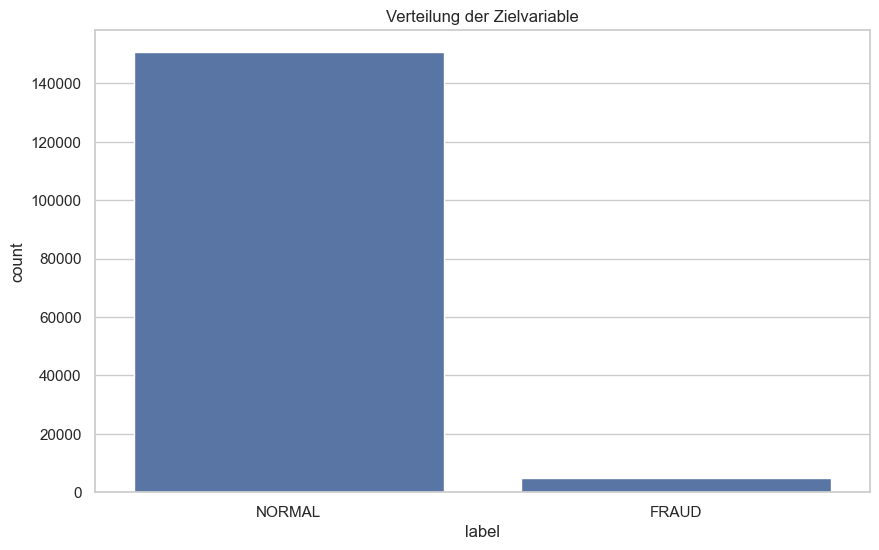

In [15]:
# --- Verteilung der Zielvariable ---
print("\nVerteilung der Zielvariable 'label':")
print(joined_transactions['label'].value_counts(normalize=True))
sns.countplot(data=joined_transactions, x='label')
plt.title('Verteilung der Zielvariable')
plt.show()

Zusammenhang zwischen Transaktionsdauer und Label

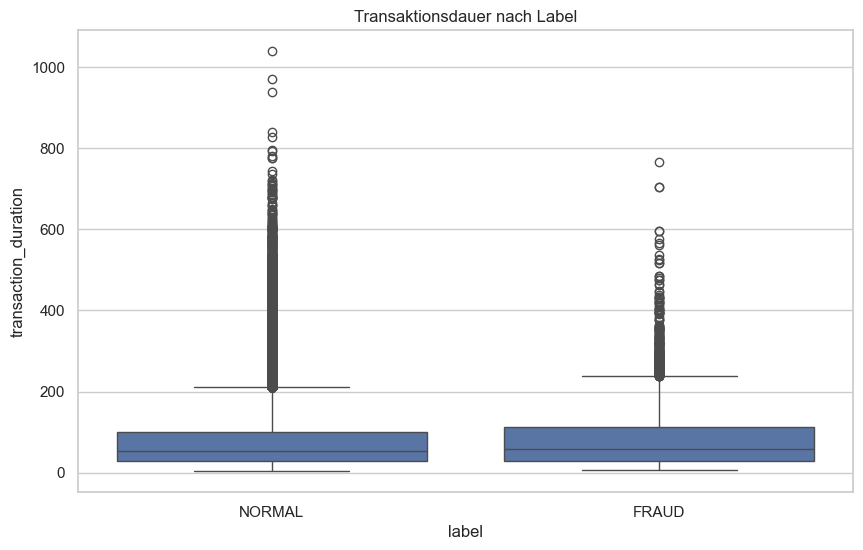

In [22]:
# --- Transaktionsdauer ---
joined_transactions['transaction_duration'] = (joined_transactions['transaction_end'] - joined_transactions['transaction_start']).dt.total_seconds()
sns.boxplot(data=joined_transactions, x='label', y='transaction_duration')
plt.title('Transaktionsdauer nach Label')
plt.show()

Deskriptive Statistik zu 'transaction_duration':
count    155692.000000
mean         77.381158
std          72.526822
min           3.453157
25%          28.168907
50%          52.856628
75%         101.405635
max        1039.334080
Name: transaction_duration, dtype: float64


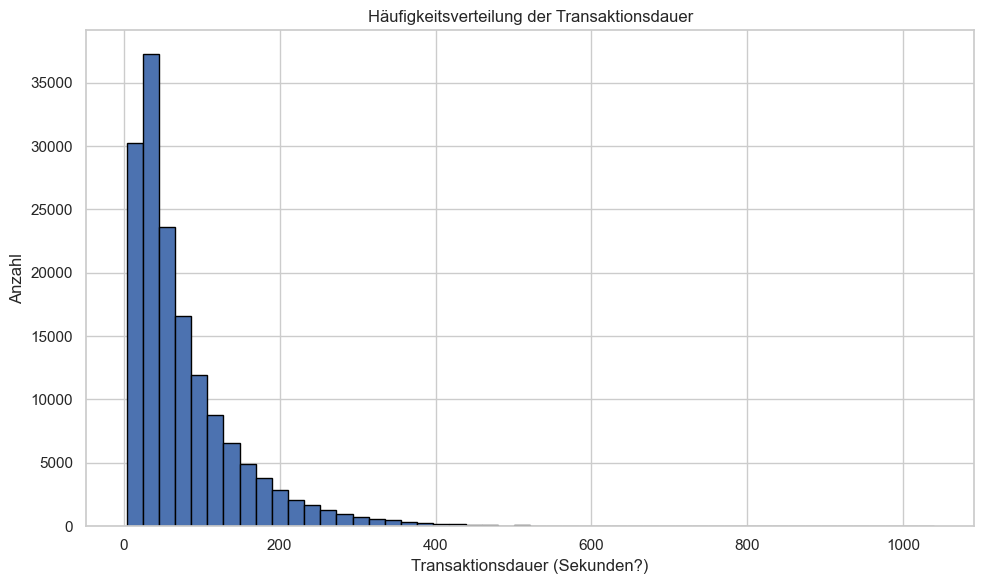

In [23]:
print("Deskriptive Statistik zu 'transaction_duration':")
print(joined_transactions['transaction_duration'].describe())

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(joined_transactions['transaction_duration'], bins=50, edgecolor='black')
plt.title('Häufigkeitsverteilung der Transaktionsdauer')
plt.xlabel('Transaktionsdauer (Sekunden)')
plt.ylabel('Anzahl')
plt.grid(True)
plt.tight_layout()
plt.show()


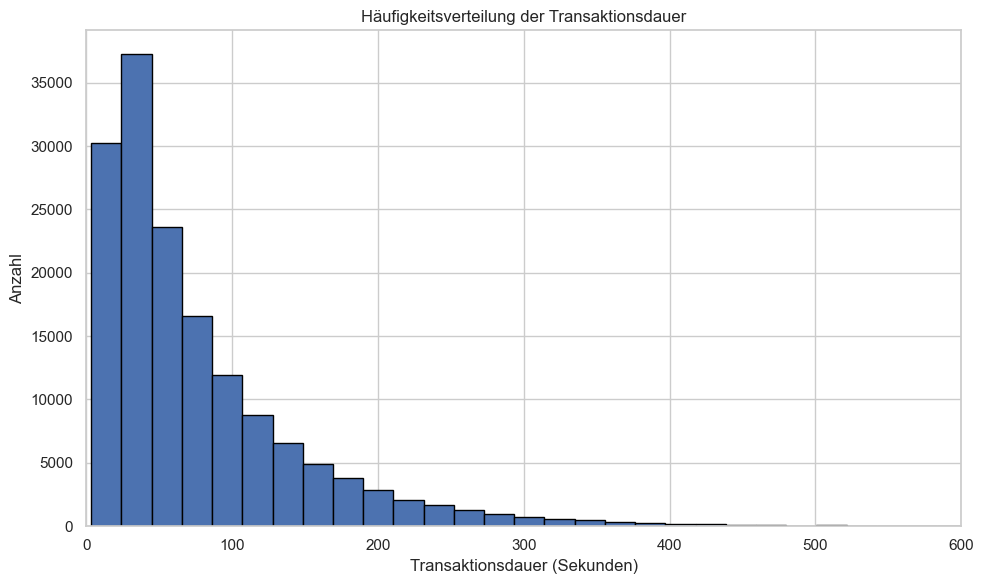

In [28]:
plt.figure(figsize=(10, 6))
plt.hist(joined_transactions['transaction_duration'], bins=50, edgecolor='black')
plt.title('Häufigkeitsverteilung der Transaktionsdauer')
plt.xlabel('Transaktionsdauer (Sekunden)')
plt.ylabel('Anzahl')
plt.xlim(0, 600)  # Begrenzung auf 0–600 Sekunden
plt.grid(True)
plt.tight_layout()
plt.show()


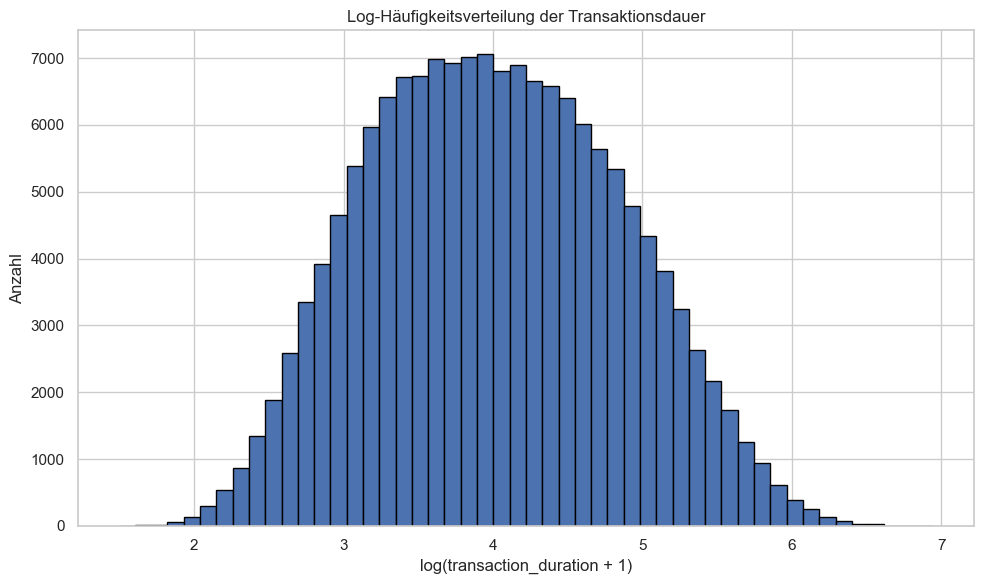

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(np.log1p(joined_transactions['transaction_duration']), bins=50, edgecolor='black')
plt.title('Log-Häufigkeitsverteilung der Transaktionsdauer')
plt.xlabel('log(transaction_duration + 1)')
plt.ylabel('Anzahl')
plt.grid(True)
plt.tight_layout()
plt.show()


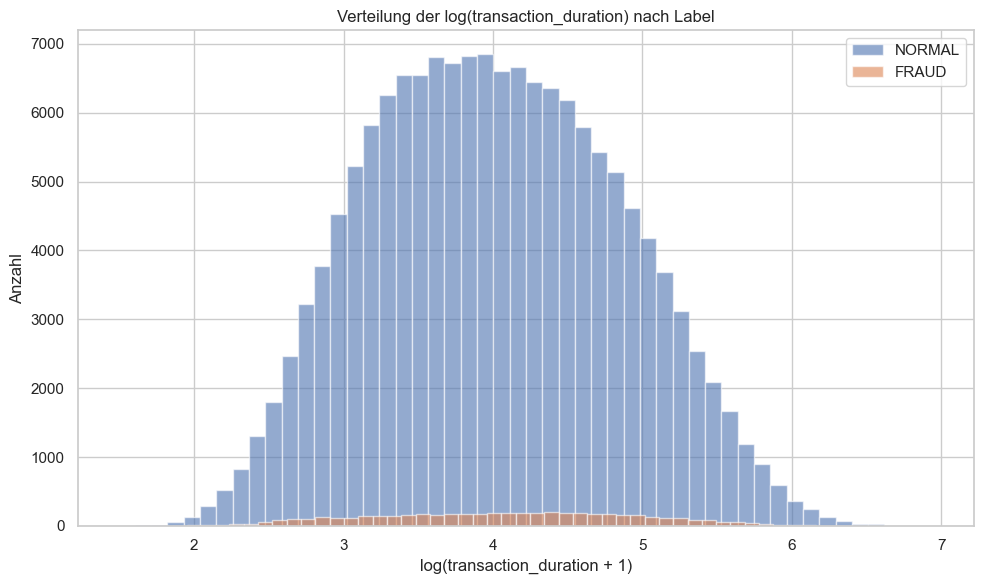

In [25]:
# log-transformierte Dauer berechnen
joined_transactions['log_transaction_duration'] = np.log1p(joined_transactions['transaction_duration'])

# Plot
plt.figure(figsize=(10, 6))
for label in joined_transactions['label'].unique():
    subset = joined_transactions[joined_transactions['label'] == label]
    plt.hist(subset['log_transaction_duration'], bins=50, alpha=0.6, label=label)

plt.title('Verteilung der log(transaction_duration) nach Label')
plt.xlabel('log(transaction_duration + 1)')
plt.ylabel('Anzahl')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [26]:
from scipy.stats import ttest_ind

# Aufteilen
fraud_vals = joined_transactions[joined_transactions['label'] == 'FRAUD']['log_transaction_duration']
normal_vals = joined_transactions[joined_transactions['label'] == 'NORMAL']['log_transaction_duration']

# t-Test durchführen
t_stat, p_value = ttest_ind(fraud_vals, normal_vals, equal_var=False)

print("t-Statistik:", t_stat)
print("p-Wert:", p_value)


t-Statistik: 4.697811956433872
p-Wert: 2.6960481712499184e-06


**Zusammenhang zwischen Transaktionsdauer und Label:** Die Transaktionsdauer (transaction_duration) wurde hinsichtlich ihrer Eignung als erklärende Variable für den Betrugsstatus (label) untersucht. Aufgrund der starken Schiefe der Originalverteilung wurde zunächst eine log-Transformation (log(transaction_duration + 1)) vorgenommen, wodurch eine nahezu normalverteilte Struktur erreicht werden konnte.
Der Vergleich der Verteilungen zeigte, dass FRAUD-Transaktionen tendenziell längere Transaktionsdauern aufweisen. Ein t-Test bestätigte diesen Unterschied als hoch signifikant (t = 4.70, p < 0.00001).
Daraus ergibt sich, dass die Transaktionsdauer – insbesondere in transformierter Form – ein relevantes Merkmal für Klassifikationsmodelle im Rahmen der Betrugserkennung darstellen kann.

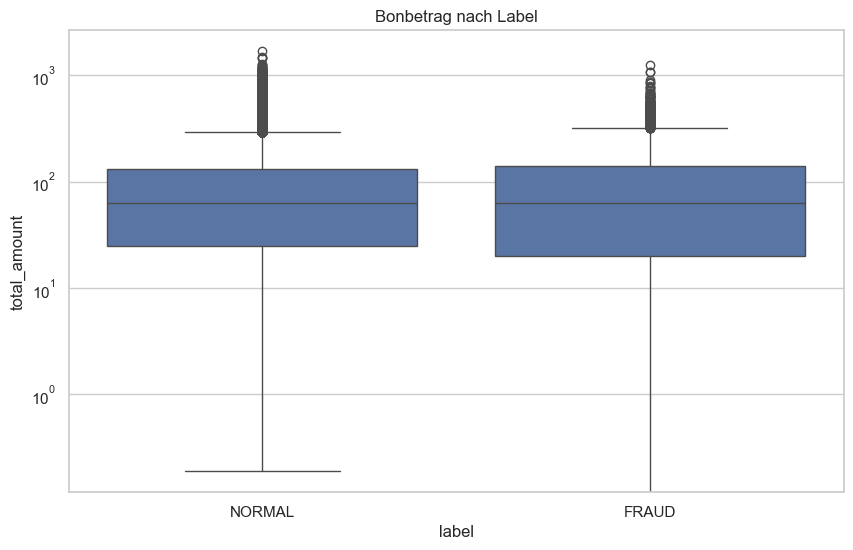

In [18]:
# --- Total Amount ---
sns.boxplot(data=joined_transactions, x='label', y='total_amount')
plt.title('Bonbetrag nach Label')
plt.yscale('log')
plt.show()

In [6]:
from scipy.stats import mannwhitneyu, chi2_contingency
from sklearn.preprocessing import LabelEncoder

In [20]:
# Transaktionsdauer als Feature anlegen
joined_transactions['transaction_duration'] = (joined_transactions['transaction_end'] - joined_transactions['transaction_start']).dt.total_seconds()

In [21]:
# --- Zielvariable in binäres Format bringen ---
le = LabelEncoder()
joined_transactions['label_bin'] = le.fit_transform(joined_transactions['label'])  # FRAUD = 1, NORMAL = 0

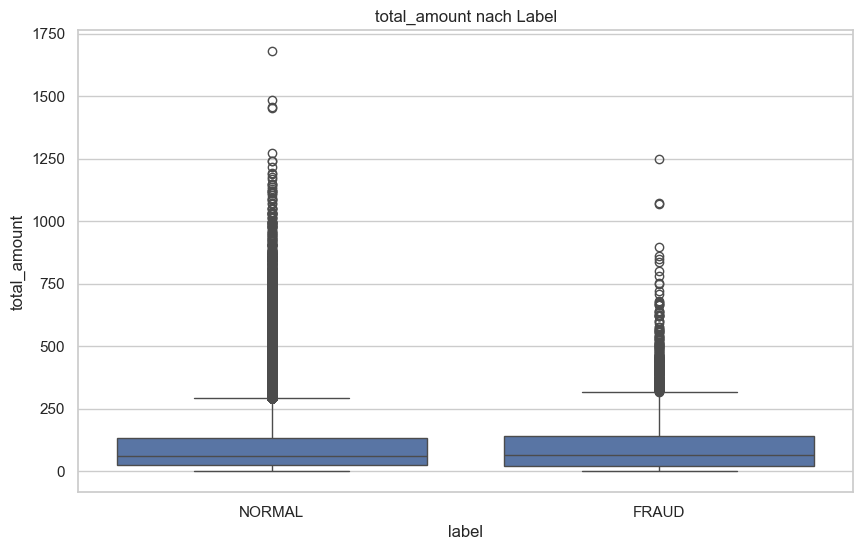

total_amount: Mann-Whitney-U-Test p-Wert = 0.0412


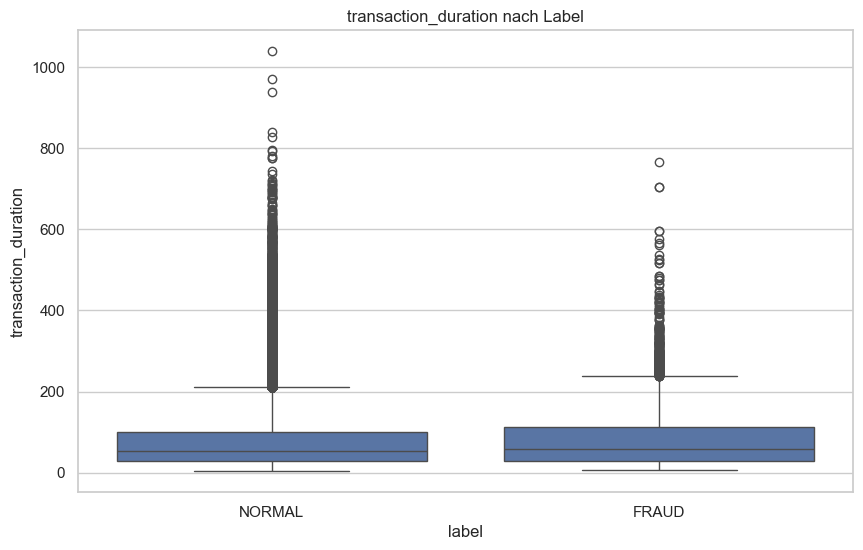

transaction_duration: Mann-Whitney-U-Test p-Wert = 0.0000


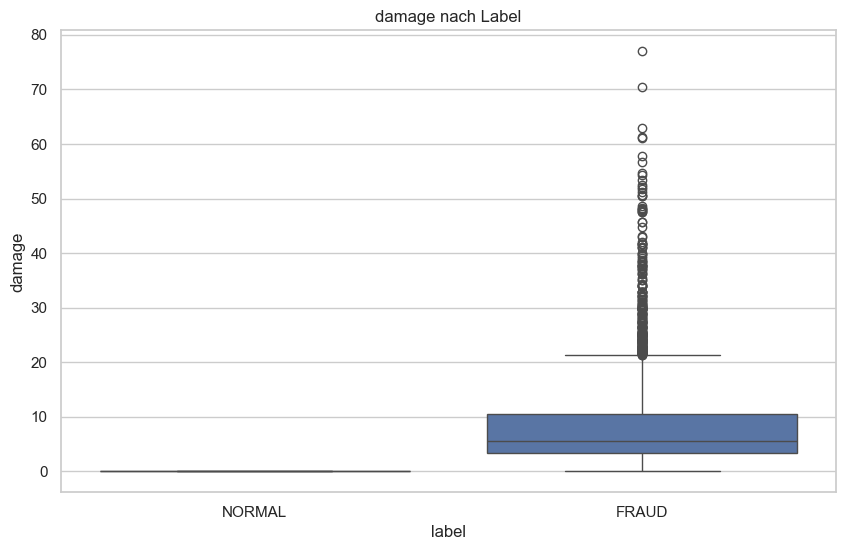

damage: Mann-Whitney-U-Test p-Wert = 0.0000


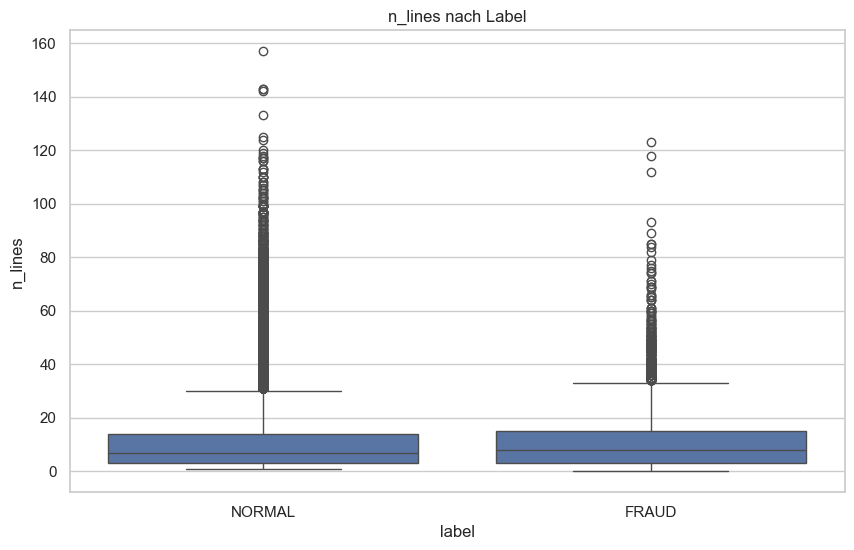

n_lines: Mann-Whitney-U-Test p-Wert = 0.0002


In [23]:
# --- Analyse numerischer Features ---
numerical_features = ['total_amount', 'transaction_duration', 'damage', 'n_lines']

for feature in numerical_features:
    sns.boxplot(data=joined_transactions, x='label', y=feature)
    plt.title(f'{feature} nach Label')
    plt.show()

    fraud_values = joined_transactions[joined_transactions['label'] == 'FRAUD'][feature].dropna()
    normal_values = joined_transactions[joined_transactions['label'] == 'NORMAL'][feature].dropna()

    stat, p = mannwhitneyu(fraud_values, normal_values, alternative='two-sided')
    print(f"{feature}: Mann-Whitney-U-Test p-Wert = {p:.4f}")


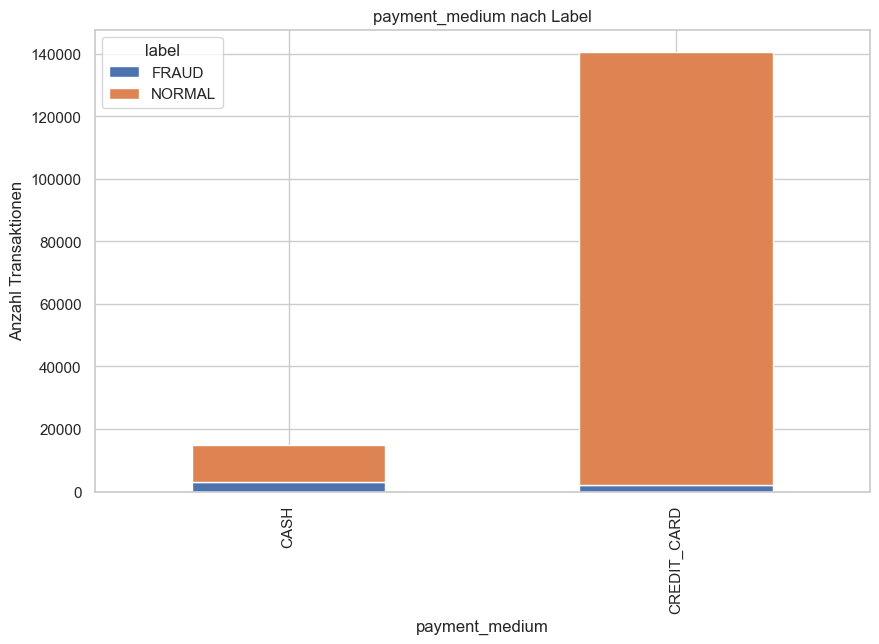

payment_medium: Chi²-Test p-Wert = 0.0000


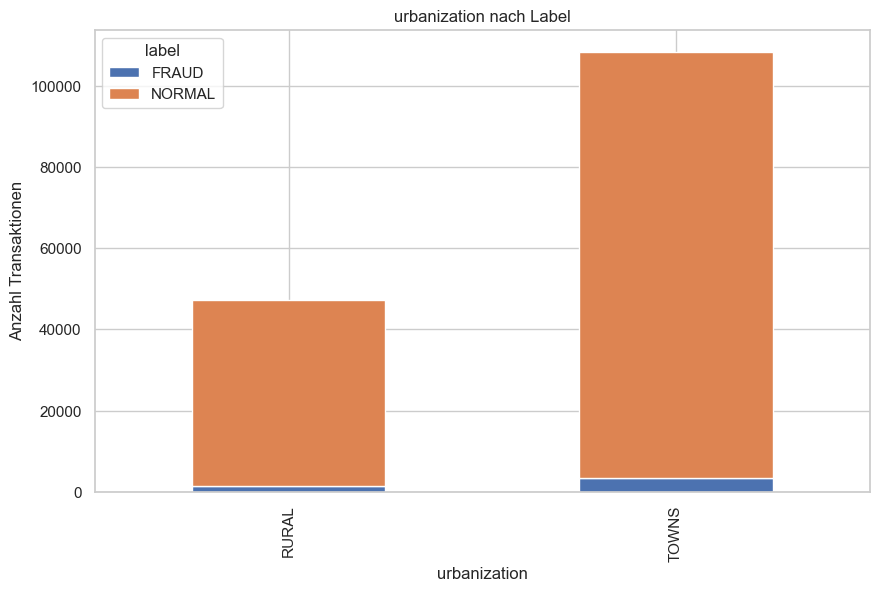

urbanization: Chi²-Test p-Wert = 0.7464


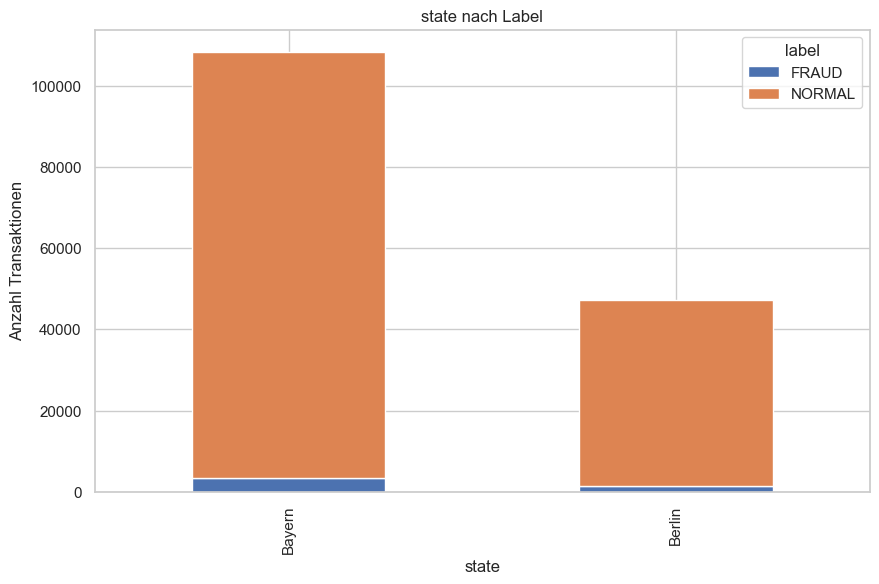

state: Chi²-Test p-Wert = 0.7464


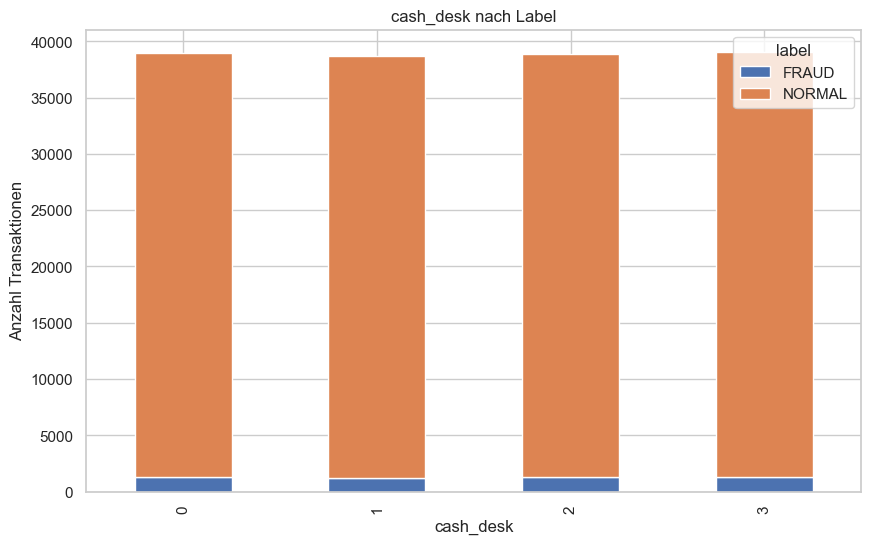

cash_desk: Chi²-Test p-Wert = 0.6781


In [7]:
# --- Analyse kategorischer Features ---
categorical_features = ['payment_medium', 'urbanization', 'state', 'cash_desk']

for feature in categorical_features:
    ctab = pd.crosstab(joined_transactions[feature], joined_transactions['label'])
    ctab.plot(kind='bar', stacked=True)
    plt.title(f'{feature} nach Label')
    plt.ylabel('Anzahl Transaktionen')
    plt.show()

    chi2, p, dof, expected = chi2_contingency(ctab)
    print(f"{feature}: Chi²-Test p-Wert = {p:.4f}")


Zusammenhang cash_desk & label

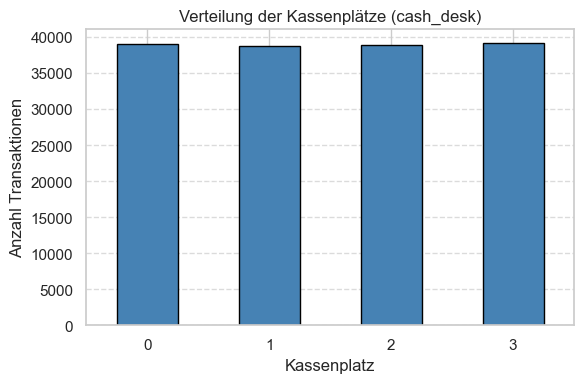

In [30]:
import matplotlib.pyplot as plt

# Häufigkeiten berechnen
cash_desk_counts = joined_transactions['cash_desk'].value_counts().sort_index()

# Plot
plt.figure(figsize=(6, 4))
cash_desk_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Verteilung der Kassenplätze (cash_desk)')
plt.xlabel('Kassenplatz')
plt.ylabel('Anzahl Transaktionen')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


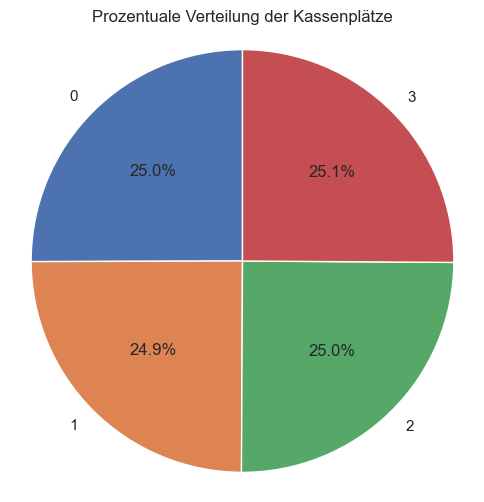

In [31]:
# Prozentuale Verteilung
cash_desk_percent = cash_desk_counts / cash_desk_counts.sum() * 100

# Plot
plt.figure(figsize=(6, 6))
plt.pie(cash_desk_percent, labels=cash_desk_percent.index, autopct='%1.1f%%', startangle=90)
plt.title('Prozentuale Verteilung der Kassenplätze')
plt.axis('equal')
plt.show()


In [32]:
# Nur relevante Spalten
df = joined_transactions[['cash_desk', 'label']]

# FRAUD-Anteil pro Kasse berechnen
fraud_rate = pd.crosstab(df['cash_desk'], df['label'], normalize='index') * 100

# Nur die FRAUD-Spalte extrahieren
fraud_rate = fraud_rate['FRAUD']


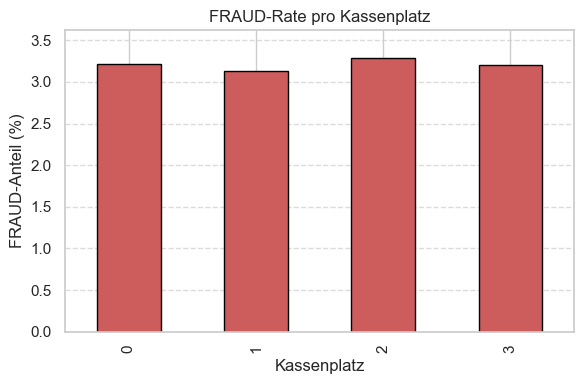

In [33]:
plt.figure(figsize=(6, 4))
fraud_rate.plot(kind='bar', color='indianred', edgecolor='black')
plt.title('FRAUD-Rate pro Kassenplatz')
plt.ylabel('FRAUD-Anteil (%)')
plt.xlabel('Kassenplatz')
plt.ylim(0, fraud_rate.max() * 1.1)  # etwas Platz nach oben
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [34]:
import pandas as pd
from scipy.stats import chi2_contingency

# Kontingenztabelle erstellen
contingency_table = pd.crosstab(joined_transactions['cash_desk'], joined_transactions['label'])

# Chi²-Test durchführen
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Ergebnisse anzeigen
print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)
print("\nErwartete Häufigkeiten unter H0:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))


Chi²-Statistik: 1.518151690376242
p-Wert: 0.6780873109339844
Freiheitsgrade: 3

Erwartete Häufigkeiten unter H0:
label            FRAUD        NORMAL
cash_desk                           
0          1252.344372  37743.655628
1          1243.769751  37485.230249
2          1248.554839  37629.445161
3          1255.331038  37833.668962


**Zusammenhang zwischen Kassenterminal und Label:** Die Verteilung der Transaktionen auf die vier verfügbaren Kassenplätze ist nahezu gleichmäßig. Jeder Kassenplatz verzeichnet ca. 25 % aller Transaktionen. Es lassen sich keine systematischen Unterschiede in der Auslastung der Kassen erkennen. Zudem besteht eine sehr gleichmäßige FRAUD-Rate über alle Kassenplätze hinweg – zwischen 3.1 % und 3.3 %, ohne nennenswerte Ausreißer. Zur Überprüfung eines möglichen Zusammenhangs zwischen dem Kassenplatz (cash_desk) und dem Transaktionslabel (label: FRAUD oder NORMAL) wurde ein Chi²-Test auf Unabhängigkeit durchgeführt. Der Test ergab keinen statistisch signifikanten Zusammenhang zwischen dem verwendeten Kassenplatz und der Betrugswahrscheinlichkeit. 
Die Variable 'cash_desk' ist daher nicht als relevanter Prädiktor für FRAUD-Transaktionen einzustufen.

In [25]:
print(joined_transactions.groupby('label')['total_amount'].median())


label
FRAUD     63.53
NORMAL    62.64
Name: total_amount, dtype: float64


Zusammenhang 'total_amount' mit label

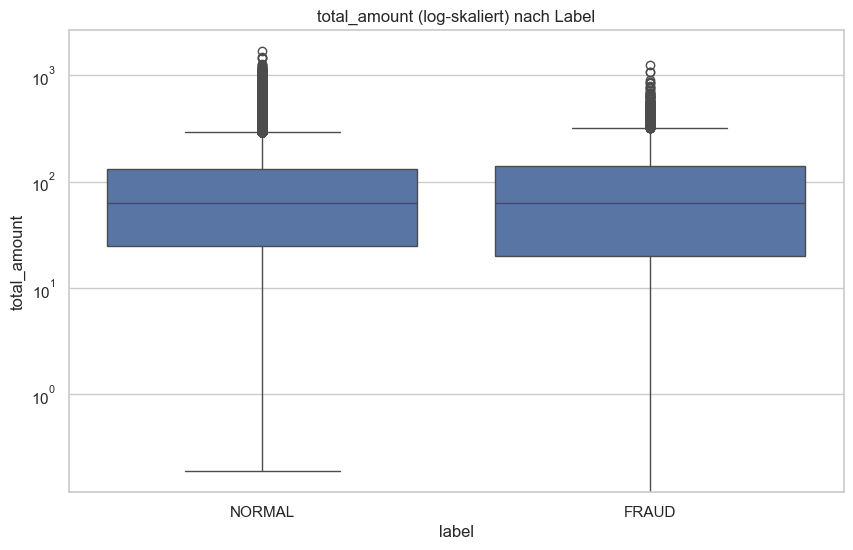

In [26]:
# Visualisierung mit log-Skalierung
sns.boxplot(data=joined_transactions, x='label', y='total_amount')
plt.yscale('log')
plt.title('total_amount (log-skaliert) nach Label')
plt.show()


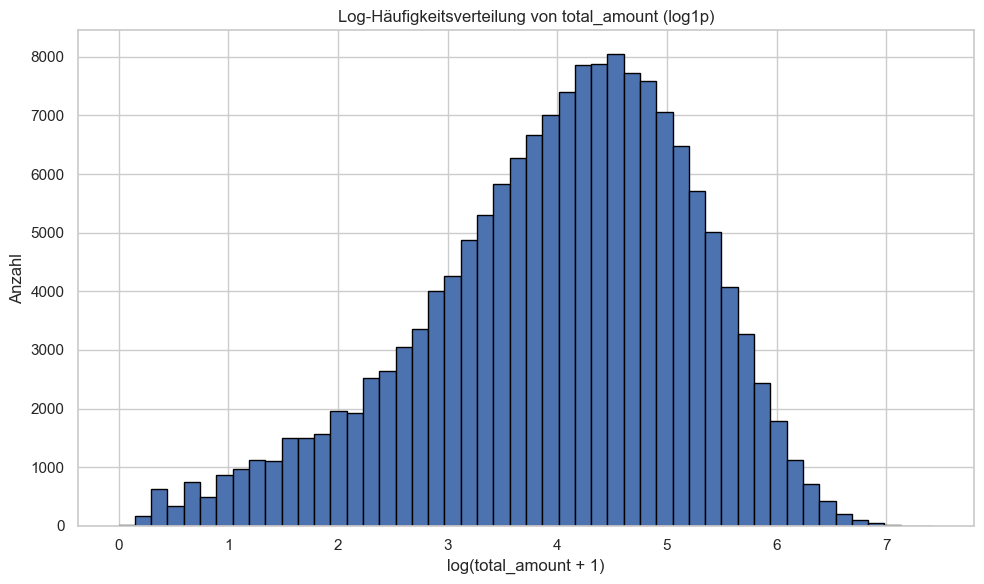

In [19]:
import numpy as np

plt.figure(figsize=(10, 6))
plt.hist(np.log1p(joined_transactions['total_amount']), bins=50, edgecolor='black')
plt.title('Log-Häufigkeitsverteilung von total_amount (log1p)')
plt.xlabel('log(total_amount + 1)')
plt.ylabel('Anzahl')
plt.grid(True)
plt.tight_layout()
plt.show()


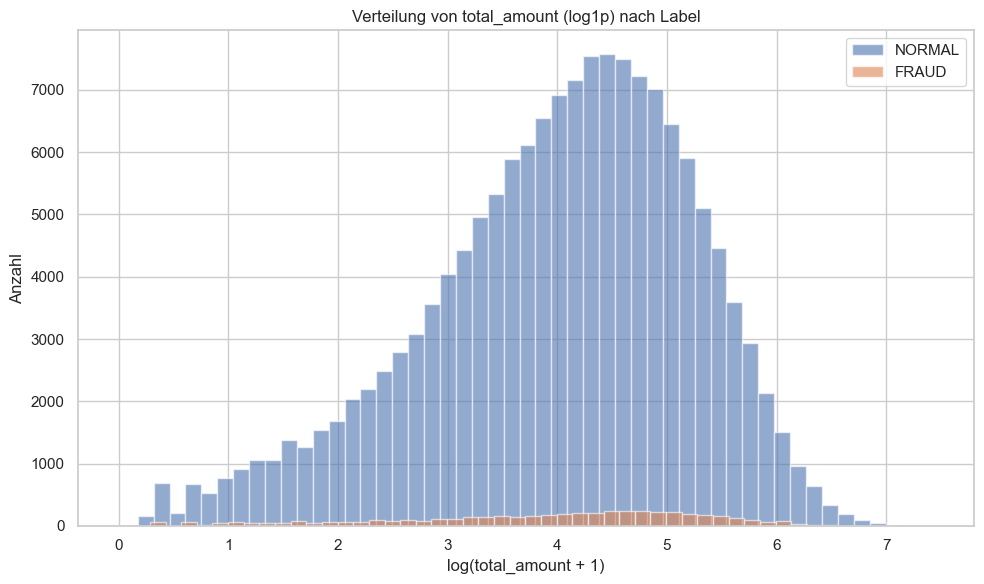

In [20]:
plt.figure(figsize=(10, 6))
for label in joined_transactions['label'].unique():
    subset = joined_transactions[joined_transactions['label'] == label]
    plt.hist(np.log1p(subset['total_amount']), bins=50, alpha=0.6, label=label)

plt.title('Verteilung von total_amount (log1p) nach Label')
plt.xlabel('log(total_amount + 1)')
plt.ylabel('Anzahl')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [21]:
from scipy.stats import ttest_ind

fraud_vals = np.log1p(joined_transactions[joined_transactions['label'] == 'FRAUD']['total_amount'])
normal_vals = np.log1p(joined_transactions[joined_transactions['label'] == 'NORMAL']['total_amount'])

t_stat, p_value = ttest_ind(fraud_vals, normal_vals, equal_var=False)

print("t-Statistik:", t_stat)
print("p-Wert:", p_value)


t-Statistik: -5.27463306188178
p-Wert: 1.3836060187539816e-07


**Zusammenhang zwischen Gesamtbetrag & Label:** Zur Prüfung, ob sich der Gesamtbetrag (total_amount) zwischen FRAUD- und NORMAL-Transaktionen systematisch unterscheidet, wurde eine log-Transformation durchgeführt und anschließend ein t-Test für unabhängige Stichproben angewendet. Der Test ergibt einen hochsignifikanten Unterschied. Die Verteilung der log-transformierten Beträge ist bei betrügerischen Transaktionen tendenziell nach rechts verschoben, d. h. höhere Beträge sind bei FRAUD überrepräsentiert. Das Merkmal 'total_amount' (log-transformiert) ist damit ein sinnvoller Prädiktor für die Klassifikation von Transaktionen und sollte in Modellierungsansätzen berücksichtigt werden.

Zusammenhang Feedback vs. Label

Prozentuale Verteilung der Labels je Kundenfeedback:
label              FRAUD  NORMAL
customer_feedback               
1.0                 2.07   97.93
2.0                 0.00  100.00
3.0                 2.50   97.50
4.0                 0.00  100.00
5.0                 2.37   97.63
6.0                 1.06   98.94
7.0                 1.07   98.93
8.0                 0.86   99.14
9.0                 1.19   98.81
10.0                3.63   96.37


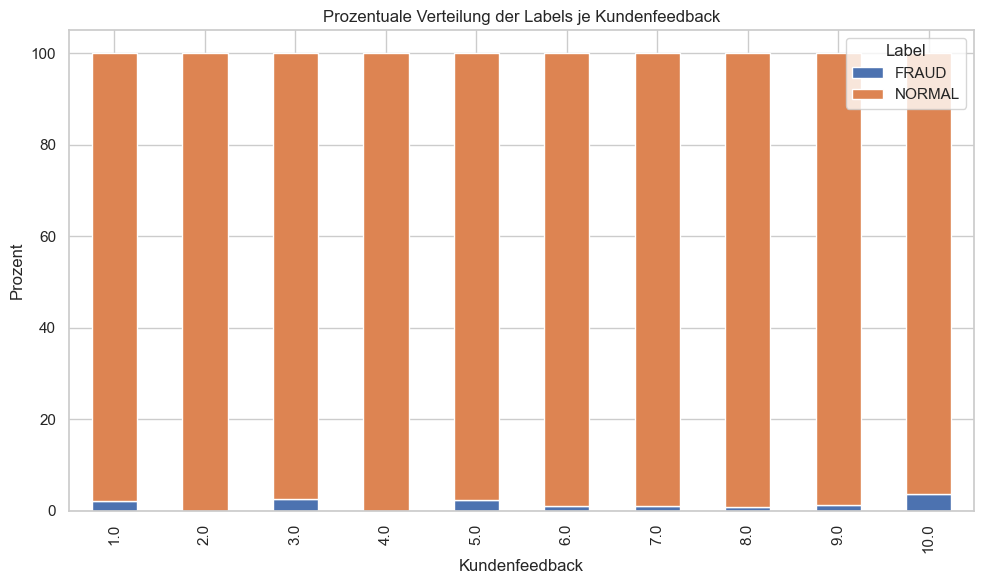

In [17]:
# Crosstab: Zeigt, wie sich das Label je customer_feedback verteilt
cross_tab = pd.crosstab(
    joined_transactions['customer_feedback'],
    joined_transactions['label'],
    normalize='index'  # Zeilenweise Prozent
) * 100

# Ausgabe der Werte
print("Prozentuale Verteilung der Labels je Kundenfeedback:")
print(cross_tab.round(2))

# Plot
cross_tab.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Prozentuale Verteilung der Labels je Kundenfeedback')
plt.ylabel('Prozent')
plt.xlabel('Kundenfeedback')
plt.legend(title='Label')
plt.tight_layout()
plt.show()


In [18]:
# Kontingenztabelle: absolute Häufigkeiten
contingency_table = pd.crosstab(joined_transactions['customer_feedback'], joined_transactions['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Ausgabe
print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)
print("\nErwartete Häufigkeiten unter H0:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))


Chi²-Statistik: 39.40154872966738
p-Wert: 9.749902688374217e-06
Freiheitsgrade: 9

Erwartete Häufigkeiten unter H0:
label                   FRAUD       NORMAL
customer_feedback                         
1.0                  7.428625   233.571375
2.0                  2.558406    80.441594
3.0                  3.698900   116.301100
4.0                  4.438681   139.561319
5.0                  6.503900   204.496100
6.0                  8.723240   274.276760
7.0                 11.528240   362.471760
8.0                 14.302415   449.697585
9.0                 15.597030   490.402970
10.0               253.220562  7961.779438


**Zusammenhang zum Customer Feedback:** Obwohl der Chi²-Test einen statistisch signifikanten Zusammenhang zwischen customer_feedback und dem Label (FRAUD, NORMAL) zeigt, ist die praktische Relevanz begrenzt. Die Visualisierung belegt, dass der Anteil betrügerischer Transaktionen über alle Feedback-Klassen hinweg auf einem sehr niedrigen Niveau liegt und nur geringfügig variiert. Dies weist auf eine nur schwache Abhängigkeit hin. customer_feedback kann somit allenfalls als ergänzendes Merkmal in einem Modell berücksichtigt werden, aber nicht als starker Prädiktor allein.

Zusammenhang Zahlungsmittel vs Label

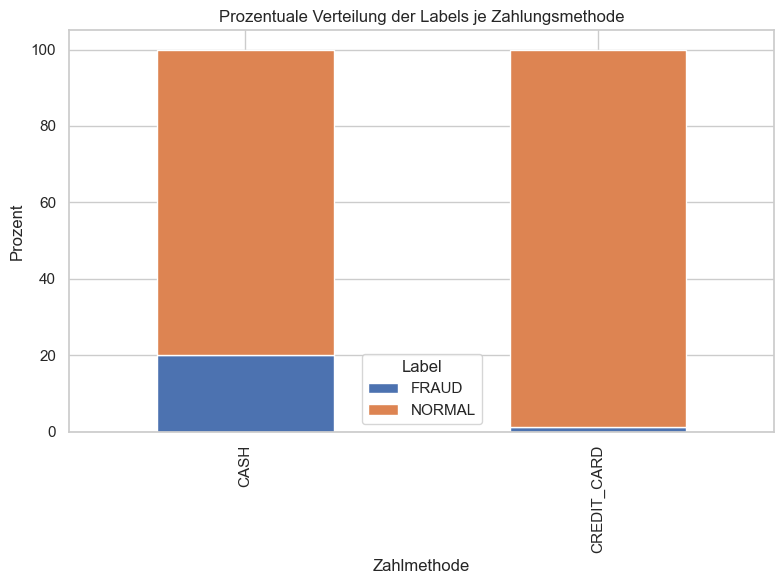

In [9]:
# Kreuztabelle: Anteil der Labels je Zahlungsmethode (normalisiert pro Zahlungsmethode)
cross_tab = pd.crosstab(joined_transactions['payment_medium'], joined_transactions['label'], normalize='index') * 100

# Plot
cross_tab.plot(kind='bar', stacked=True, figsize=(8, 6))
plt.title('Prozentuale Verteilung der Labels je Zahlungsmethode')
plt.ylabel('Prozent')
plt.xlabel('Zahlmethode')
plt.legend(title='Label')
plt.tight_layout()
plt.show()


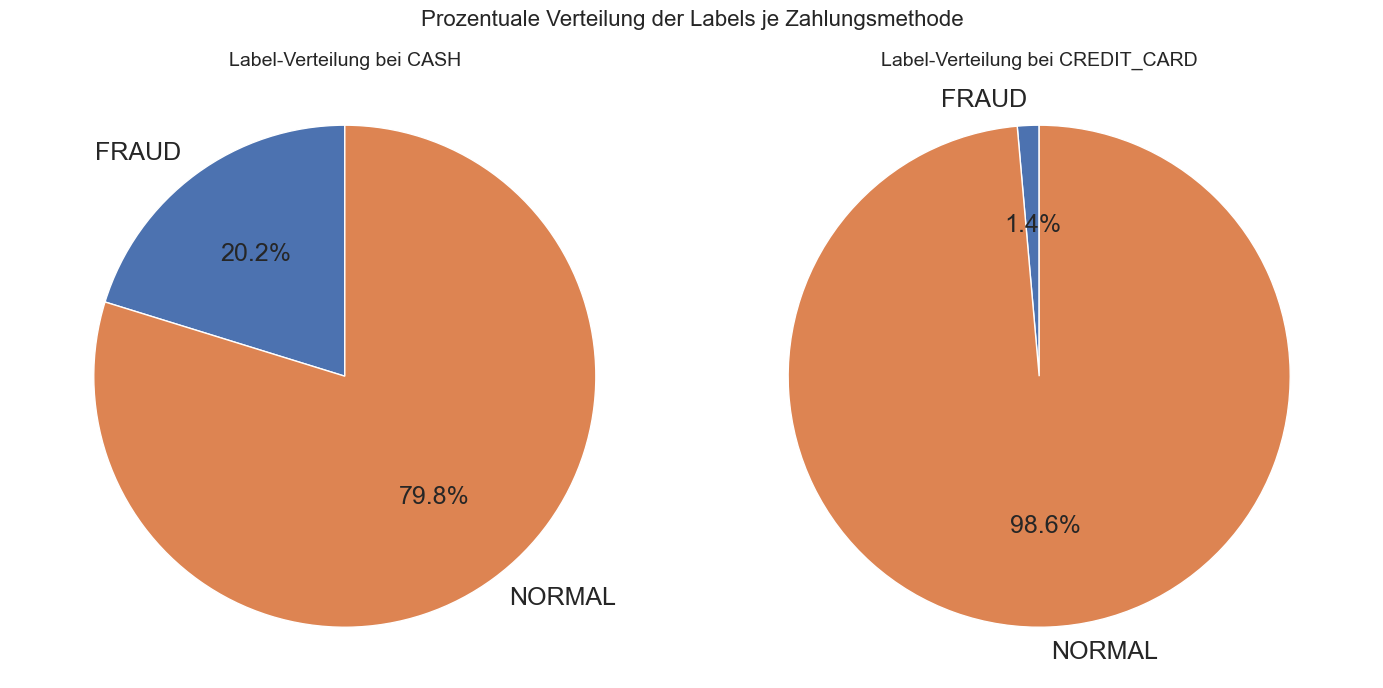

In [15]:
# Gruppieren und Prozentanteile berechnen
grouped = joined_transactions.groupby('payment_medium')['label'].value_counts(normalize=True).unstack() * 100

# Plot-Setup mit größerer Schrift
fig, axes = plt.subplots(1, 2, figsize=(14, 7))  # Größerer Plot

# Pie Chart für CASH
axes[0].pie(
    grouped.loc['CASH'],
    labels=grouped.columns,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 18}  # größere Schrift
)
axes[0].set_title('Label-Verteilung bei CASH', fontsize=14)
axes[0].axis('equal')

# Pie Chart für CREDIT_CARD
axes[1].pie(
    grouped.loc['CREDIT_CARD'],
    labels=grouped.columns,
    autopct='%1.1f%%',
    startangle=90,
    textprops={'fontsize': 18}  # größere Schrift
)
axes[1].set_title('Label-Verteilung bei CREDIT_CARD', fontsize=14)
axes[1].axis('equal')

plt.suptitle('Prozentuale Verteilung der Labels je Zahlungsmethode', fontsize=16)
plt.tight_layout()
plt.show()


In [11]:
# Kontingenztabelle erstellen (absolute Häufigkeiten)
contingency_table = pd.crosstab(joined_transactions['payment_medium'], joined_transactions['label'])

# Chi²-Test durchführen
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Ergebnisse ausgeben
print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)
print("\nErwartete Häufigkeiten unter H0:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))


Chi²-Statistik: 15467.606163792465
p-Wert: 0.0
Freiheitsgrade: 1

Erwartete Häufigkeiten unter H0:
label                 FRAUD         NORMAL
payment_medium                            
CASH             482.298384   14535.701616
CREDIT_CARD     4517.701616  136156.298384


• **Zusammenhang zum Zahlungsmittel:** Das Merkmal payment_medium zeigte einen hochsignifikanten Zusammenhang mit der Zielvariable (p < 0.0001, Chi²-Test). Insbesondere ist ein überproportionaler Anteil betrügerischer Transaktionen bei Barzahlung zu beobachten. Dieses Merkmal wird daher als potenziell erklärungsrelevant für spätere Modellierungen berücksichtigt.

Zusammenhang zwischen label und Standort

In [45]:
# Hilfsfunktion für Kreisdiagramme pro Kategorieausprägung
def plot_pie_charts_by_column(df, column_name):
    unique_vals = df[column_name].unique()
    n = len(unique_vals)
    
    # Dynamisches Layout berechnen
    ncols = 3
    nrows = -(-n // ncols)  # Decke auf (ceil)
    
    fig, axes = plt.subplots(nrows, ncols, figsize=(ncols * 4, nrows * 4))
    axes = axes.flatten()
    
    for i, val in enumerate(unique_vals):
        subset = df[df[column_name] == val]
        label_counts = subset['label'].value_counts(normalize=True) * 100
        
        axes[i].pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90)
        axes[i].set_title(f"{val}")
        axes[i].axis('equal')
    
    # Leere Subplots ausblenden
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])
    
    plt.suptitle(f'Label-Verteilung für Attribut {column_name}', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


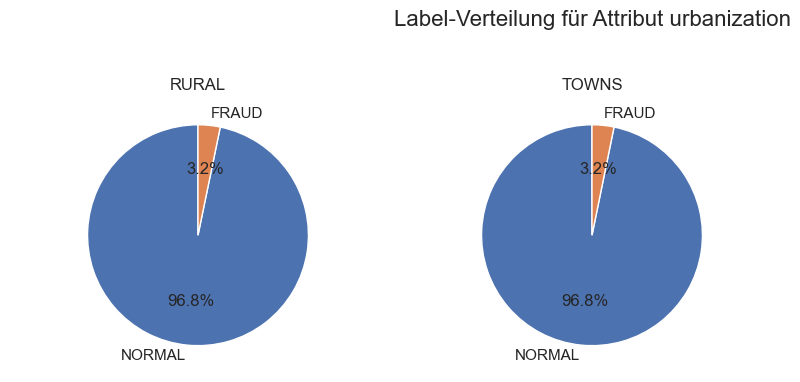

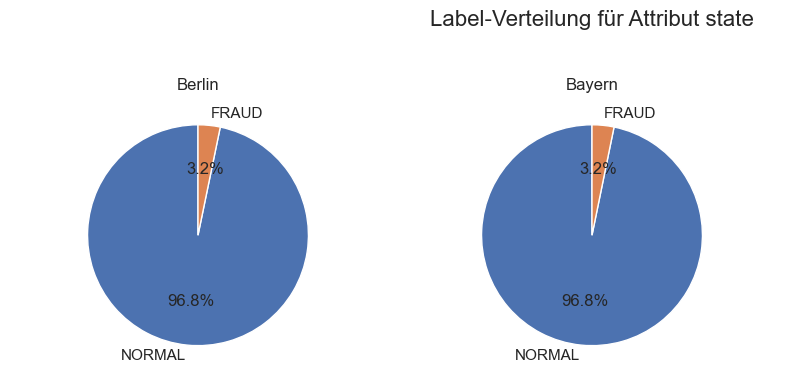

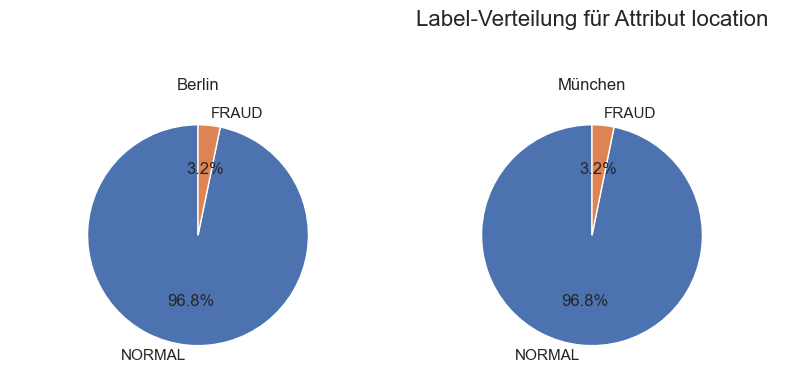

In [46]:
plot_pie_charts_by_column(joined_transactions, 'urbanization')
plot_pie_charts_by_column(joined_transactions, 'state')
plot_pie_charts_by_column(joined_transactions, 'location')

• **Zusammenhang zur Urbanisierung:** In den kontrollierten Transaktionen tauchten nur Gemeinden und ländliche Gebiete auf. Für Urbanisierung zeigte sich kein signifikanter Zusammenhang mit dem Label. Sowohl in Gemeinden als auch in ländlichen Gebieten liegt der Anteil an Frauds bei rund 3,2 %. Der Chi²-Test konnte eine Unabhängigkeit der Urbanisierung vom Label ebenfalls bestätigen. Das Attribut 'urbanization' wird daher als nicht erklärungsrelevant eingestuft.

• **Zusammenhang zum Bundesland:** In den kontrollierten Transaktionen tauchten nur Bayern und Berlin auf. Für das Bundesland zeigte sich kein signifikanter Zusammenhang mit dem Label. Sowohl in Bayern als auch in Berlin liegt der Anteil an Frauds bei rund 3,2 %. Der Chi²-Test konnte eine Unabhängigkeit des Bundeslandes vom Label ebenfalls bestätigen. Das Attribut 'state' wird daher als nicht erklärungsrelevant eingestuft.

• **Zusammenhang zum Ort:** In den kontrollierten Transaktionen tauchten nur München und Berlin auf. Für den Ort zeigte sich kein signifikanter Zusammenhang mit dem Label. Sowohl in München als auch in Berlin liegt der Anteil an Frauds bei rund 3,2 %. Der Chi²-Test konnte eine Unabhängigkeit des Ortes vom Label ebenfalls bestätigen. Das Attribut 'location' wird daher als nicht erklärungsrelevant eingestuft.

Zusammenhang zwischen Labels und Warenkorbgröße

In [47]:
print("Deskriptive Statistik zu 'n_lines':")
print(joined_transactions['n_lines'].describe())

Deskriptive Statistik zu 'n_lines':
count    155692.000000
mean         10.543785
std          11.009898
min           0.000000
25%           3.000000
50%           7.000000
75%          14.000000
max         157.000000
Name: n_lines, dtype: float64


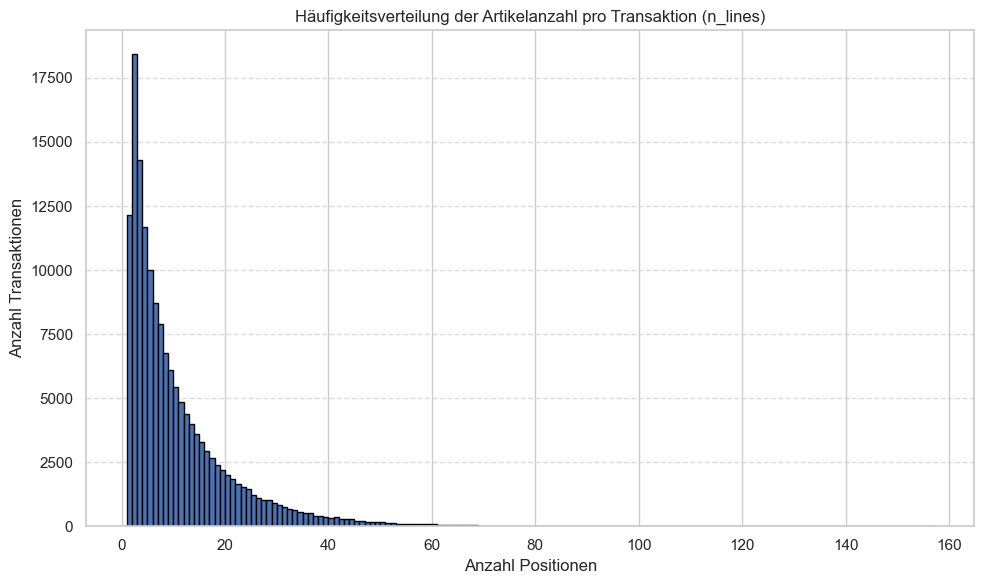

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(joined_transactions['n_lines'], bins=range(1, joined_transactions['n_lines'].max()+1), edgecolor='black')
plt.title('Häufigkeitsverteilung der Artikelanzahl pro Transaktion (n_lines)')
plt.xlabel('Anzahl Positionen')
plt.ylabel('Anzahl Transaktionen')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

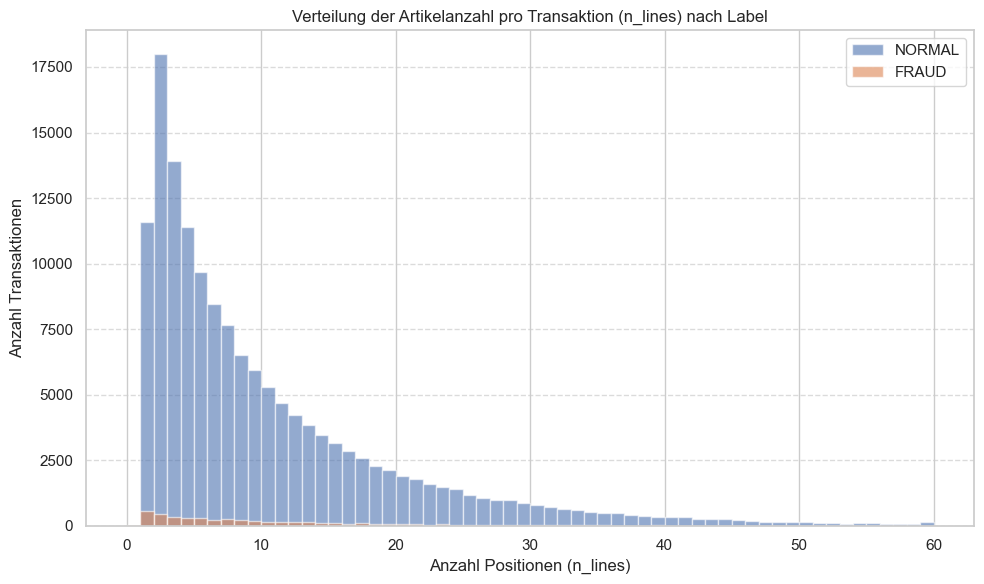

In [49]:
plt.figure(figsize=(10, 6))
for label in joined_transactions['label'].unique():
    subset = joined_transactions[joined_transactions['label'] == label]
    plt.hist(subset['n_lines'], bins=range(0, 61), alpha=0.6, label=label)

plt.title('Verteilung der Artikelanzahl pro Transaktion (n_lines) nach Label')
plt.xlabel('Anzahl Positionen (n_lines)')
plt.ylabel('Anzahl Transaktionen')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [50]:
fraud_vals = joined_transactions[joined_transactions['label'] == 'FRAUD']['n_lines']
normal_vals = joined_transactions[joined_transactions['label'] == 'NORMAL']['n_lines']

# Welch's t-Test (robust bei ungleicher Varianz & Gruppengröße)
t_stat, p_value = ttest_ind(fraud_vals, normal_vals, equal_var=False)

print("t-Statistik:", t_stat)
print("p-Wert:", p_value)


t-Statistik: 5.231137717194166
p-Wert: 1.749730477308483e-07


• **Zusammenhang zur Warenkorbgröße:** Die Verteilung der Anzahl der Artikelpositionen je Transaktion ist stark rechtsschief, mit einem Mittelwert von ca. 10,5 Positionen und einem Median von 7. Die große Mehrheit der Transaktionen besteht aus wenigen Artikeln, während einzelne Ausreißer mit über 100 Positionen auftreten. 
Ein Vergleich zwischen FRAUD- und NORMAL-Transaktionen zeigt visuell, dass betrügerische Transaktionen tendenziell mit einem geringeren Warenkorbumfang einhergehen. Ein t-Test zur Prüfung der Mittelwertunterschiede ergab zudem einen signifikanten Unterschied, was darauf hindeutet, dass das Attribut 'n_lines' ein relevantes für die Unterscheidung zwischen betrügerischen und normalen Transaktionen ist.

## Tabelle joined_transactionlines

In [28]:
joined_transactionlines.dtypes

id                                 int64
transaction_id                    object
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                          bool
camera_product_similar            object
camera_certainty                 float64
base_product_id                   object
category                          object
price                            float64
popularity                       float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object

In [29]:
joined_transactionlines.shape

(16620157, 18)

In [30]:
joined_transactionlines.head(3)

,id,transaction_id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,base_product_id,category,price,popularity,valid_from,valid_to,sold_by_weight,weight,age_restricted
0,1,107398f1-e808-4a65-835e-2d22593d727a,bcc0362e-77a8-4f7e-9b8c-9b07dcd05ba9,2022-02-02 09:04:02.006481,27.0,32.13,False,False,0.283942,7714771d-0aaf-4662-87a3-ed28d9ffcde1,FRUITS_VEGETABLES_PIECES,1.19,0.157641,2019-10-21,NaN,False,1.489696,False
1,2,107398f1-e808-4a65-835e-2d22593d727a,bd0d7a73-a63d-45ca-924c-4077131bd003,2022-02-02 09:04:07.190344,24.0,30.96,False,True,0.246889,bd0d7a73-a63d-45ca-924c-4077131bd003,FRUITS_VEGETABLES_PIECES,1.29,0.154519,2022-01-01,2022-02-03,False,5.023234,False
2,3,107398f1-e808-4a65-835e-2d22593d727a,a047c7f4-ef06-4668-85a4-a2dbd8c8d8c0,2022-02-02 09:04:09.745149,1.0,6.19,False,True,0.296224,0843450f-5325-4194-a897-37fcfab7c632,FROZEN_GOODS,6.19,0.057993,2021-07-24,2023-04-27,False,1.850000,False


Duplikate prüfen

In [31]:
# Prüft, ob vollständige Duplikate (identische Zeilen) existieren
duplicate_rows_lines = joined_transactionlines[joined_transactionlines.duplicated()]
print(f"Anzahl vollständig doppelter Zeilen: {len(duplicate_rows_lines)}")

Anzahl vollständig doppelter Zeilen: 0


In [32]:
# spalten löschen weil irrelevant
joined_transactionlines.drop(columns=['base_product_id'], inplace=True)

In [33]:
# spalten löschen weil irrelevant
joined_transactionlines.drop(columns=['popularity'], inplace=True)

Fehlende Werte

In [34]:
missing_values = joined_transactionlines.isnull().sum()
print(missing_values)

id                               0
transaction_id                   0
product_id                     199
timestamp                        0
pieces_or_weight                 0
sales_price                      0
was_voided                       0
camera_product_similar       41705
camera_certainty             41705
category                       199
price                          199
valid_from                     199
valid_to                  11917185
sold_by_weight                 199
weight                       51326
age_restricted                 199
dtype: int64


bereinigen

In [35]:
# Gültigkeit: Fehlende 'valid_to' → Platzhalterdatum als "offen"
joined_transactionlines['valid_to'].fillna(pd.to_datetime("2099-12-31"), inplace=True)

# Gewicht: Fehlende Werte = vermutlich nicht gewichtsbasierte Produkte → 0.0
joined_transactionlines['weight'].fillna(0.0, inplace=True)

In [36]:
# Zeilen mit fehlendem product_id löschen
joined_transactionlines.dropna(subset=['product_id'], inplace=True)


In [37]:
joined_transactionlines.dtypes

id                                 int64
transaction_id                    object
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                          bool
camera_product_similar            object
camera_certainty                 float64
category                          object
price                            float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object

In [38]:
missing_values = joined_transactionlines.isnull().sum()
print(missing_values)

id                            0
transaction_id                0
product_id                    0
timestamp                     0
pieces_or_weight              0
sales_price                   0
was_voided                    0
camera_product_similar    41705
camera_certainty          41705
category                      0
price                         0
valid_from                    0
valid_to                      0
sold_by_weight                0
weight                        0
age_restricted                0
dtype: int64


Sind alle transaction_ids in joined_transactionlines auch in joined_transactions enthalten?

Anzahl der Positionen pro Transaktion: Konsistenz mit n_lines

In [41]:
# Tatsächliche Anzahl pro Transaktion
line_counts = joined_transactionlines.groupby('transaction_id').size()

# Merge mit joined_transactions, um Vergleich zu ermöglichen
joined_transactions['actual_n_lines'] = joined_transactions['transaction_id'].map(line_counts)

# Differenz prüfen
mismatches = joined_transactions[joined_transactions['n_lines'] != joined_transactions['actual_n_lines']]
print(f"Anzahl Transaktionen mit abweichender Artikelanzahl: {len(mismatches)}")


Anzahl Transaktionen mit abweichender Artikelanzahl: 11371


In [42]:
# Ursache finden
problem_ids = mismatches['transaction_id']
problem_lines = joined_transactionlines[joined_transactionlines['transaction_id'].isin(problem_ids)]

# Anteil voided Artikel in problematischen Transaktionen
voided_ratio = problem_lines['was_voided'].mean()
print(f"Anteil voided Artikel in problematischen Transaktionen: {voided_ratio:.2%}")


Anteil voided Artikel in problematischen Transaktionen: 4.99%


In [43]:
# Für problematische Transaktionen: wie viele voided-Zeilen existieren?
voided_lines = problem_lines[problem_lines['was_voided']]
voided_counts = voided_lines.groupby('transaction_id').size()

# Differenz von tatsächlicher und erwarteter Anzahl
mismatches['voided_count'] = mismatches['transaction_id'].map(voided_counts).fillna(0)
mismatches['n_line_diff'] = mismatches['actual_n_lines'] - mismatches['n_lines']

# Stimmen voided_count und n_line_diff grob überein?
correlation = mismatches[['voided_count', 'n_line_diff']].corr()
print(correlation)


              voided_count  n_line_diff
voided_count           1.0          1.0
n_line_diff            1.0          1.0


C:\Users\sofie\AppData\Local\Temp\ipykernel_39536\2354743302.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches['voided_count'] = mismatches['transaction_id'].map(voided_counts).fillna(0)
C:\Users\sofie\AppData\Local\Temp\ipykernel_39536\2354743302.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mismatches['n_line_diff'] = mismatches['actual_n_lines'] - mismatches['n_lines']


# Join der 'joined_transactions'-Tabelle mit 'joines_transactionlines'-Tabelle (nur Label)

In [51]:
joined_transactionsClean = joined_transactions[joined_transactions['label'].isin(['NORMAL', 'FRAUD'])].copy()

In [52]:
joined_transactionsClean.shape

(155692, 18)

In [53]:
joined_transactionsClean.dtypes

transaction_id                      object
store_id                            object
cash_desk                            int64
transaction_start           datetime64[us]
transaction_end             datetime64[us]
total_amount                       float64
n_lines                              int64
payment_medium                      object
customer_feedback                  float64
damage                             float64
label                               object
opening_date                        object
location                            object
state                               object
urbanization                        object
sco_introduction                    object
transaction_duration               float64
log_transaction_duration           float64
dtype: object

In [54]:
# joined_transactions auf die zwei relevanten Spalten reduzieren
joined_transactionsLabel = joined_transactionsClean[['transaction_id', 'label']].copy()

In [55]:
# Merge durchführen (left join: nur Zeilen mit gültigem Label bekommen eins)
joined_tables = joined_transactionsLabel.merge(joined_transactionlines, on='transaction_id', how='left')

In [56]:
joined_tables.shape

(1653956, 19)

In [57]:
joined_tables.dtypes

transaction_id                    object
label                             object
id                               float64
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                        object
camera_product_similar            object
camera_certainty                 float64
base_product_id                   object
category                          object
price                            float64
popularity                       float64
valid_from                        object
valid_to                          object
sold_by_weight                    object
weight                           float64
age_restricted                    object
dtype: object

Strings in bool umwandeln und dann in 0/1 konvertieren

In [49]:
print(joined_tables['label'].unique())
print(joined_tables['was_voided'].unique())
print(joined_tables['camera_product_similar'].unique())
print(joined_tables['sold_by_weight'].unique())
print(joined_tables['age_restricted'].unique())

['NORMAL' 'FRAUD']
[False True nan]
[False True None nan]
[False True nan]
[False True nan]


In [53]:
# Mapping definieren
label_mapping = {'NORMAL': 0, 'FRAUD': 1}

# Spalte 'label' umwandeln
joined_tables['label'] = joined_tables['label'].map(label_mapping)

# Optional: Ergebnis prüfen
print(joined_tables['label'].value_counts())

label
0    1596176
1      57768
Name: count, dtype: int64


In [55]:
# Mapping definieren
bool_map = {False: 0, True: 1, None: -1, pd.NA: -1, np.nan: -1}

# Spalten umwandeln
joined_tables['was_voided'] = joined_tables['was_voided'].map(bool_map)
joined_tables['camera_product_similar'] = joined_tables['camera_product_similar'].map(bool_map)
joined_tables['sold_by_weight'] = joined_tables['sold_by_weight'].map(bool_map)
joined_tables['age_restricted'] = joined_tables['age_restricted'].map(bool_map)

# Prüfen
print(joined_tables[['was_voided', 'camera_product_similar', 'sold_by_weight', 'age_restricted']].dtypes)
print(joined_tables[['was_voided', 'camera_product_similar', 'sold_by_weight', 'age_restricted']].isna().sum())
print(joined_tables['was_voided'].value_counts())
print(joined_tables['camera_product_similar'].value_counts())
print(joined_tables['sold_by_weight'].value_counts())
print(joined_tables['age_restricted'].value_counts())

was_voided                float64
camera_product_similar    float64
sold_by_weight            float64
age_restricted            float64
dtype: object
was_voided                   1
camera_product_similar    4169
sold_by_weight               1
age_restricted               1
dtype: int64
was_voided
0.0    1641583
1.0      12360
Name: count, dtype: int64
camera_product_similar
1.0    1605326
0.0      44449
Name: count, dtype: int64
sold_by_weight
0.0    1649772
1.0       4171
Name: count, dtype: int64
age_restricted
0.0    1650344
1.0       3599
Name: count, dtype: int64


In [ ]:
print(joined_tables.dtypes) 

transaction_id                    object
label                              int64
id                               float64
product_id                        object
timestamp                 datetime64[us]
pieces_or_weight                 float64
sales_price                      float64
was_voided                       float64
camera_product_similar           float64
camera_certainty                 float64
category                          object
price                            float64
valid_from                        object
valid_to                          object
sold_by_weight                   float64
weight                           float64
age_restricted                   float64
dtype: object


In [57]:
joined_tables.shape

(1653944, 17)

In [58]:
joined_tables.head(3) 

,transaction_id,label,id,product_id,timestamp,pieces_or_weight,sales_price,was_voided,camera_product_similar,camera_certainty,category,price,valid_from,valid_to,sold_by_weight,weight,age_restricted
0,b642f9b6-43b5-413d-ad08-b4bf4b664b52,0,1.0,a226d3bd-ff09-479f-bb92-45e5ba7957b6,2022-02-02 08:07:19.885611,12.0,9.48,0.0,0.0,0.276115,FRUITS_VEGETABLES_PIECES,0.79,2022-01-24,2022-02-18,0.0,1.796972,0.0
1,b642f9b6-43b5-413d-ad08-b4bf4b664b52,0,2.0,c72b91ce-e404-4af5-983f-da26516b7c1e,2022-02-02 08:07:32.489706,2.0,2.98,0.0,0.0,0.295624,BEVERAGES,1.49,2016-10-02,2023-04-18,0.0,0.500000,0.0
2,b642f9b6-43b5-413d-ad08-b4bf4b664b52,0,3.0,687857ba-8497-4385-9a9a-9b71bfe012d5,2022-02-02 08:07:39.918750,6.0,8.34,0.0,0.0,0.302720,FRUITS_VEGETABLES_PIECES,1.39,2015-12-19,2099-12-31 00:00:00,0.0,1.184659,0.0


fehlende werte

In [59]:
missing_values2 = joined_tables.isnull().sum()
print(missing_values2)

transaction_id               0
label                        0
id                           1
product_id                   1
timestamp                    1
pieces_or_weight             1
sales_price                  1
was_voided                   1
camera_product_similar    4169
camera_certainty          4169
category                     1
price                        1
valid_from                   1
valid_to                     1
sold_by_weight               1
weight                       1
age_restricted               1
dtype: int64


In [58]:
joined_tables = joined_tables[~joined_tables['product_id'].isna()]

In [59]:
# Zeilen anzeigen, bei denen product_id fehlt (NaN)
missing_product_id = joined_tables[joined_tables['product_id'].isna()]

# Ausgabe anzeigen
print(missing_product_id)


Empty DataFrame
Columns: [transaction_id, label, id, product_id, timestamp, pieces_or_weight, sales_price, was_voided, camera_product_similar, camera_certainty, base_product_id, category, price, popularity, valid_from, valid_to, sold_by_weight, weight, age_restricted]
Index: []


In [61]:
missing_values3 = joined_tables.isnull().sum()
print(missing_values3)

transaction_id               0
label                        0
id                           0
product_id                   0
timestamp                    0
pieces_or_weight             0
sales_price                  0
was_voided                   0
camera_product_similar    4168
camera_certainty          4168
category                     0
price                        0
valid_from                   0
valid_to                     0
sold_by_weight               0
weight                       0
age_restricted               0
dtype: int64


--> eine Transaktion hatte keine Produkte/Lines und wurde daher gelöscht.

In [62]:
# Transaktion mit spezifischer transaction_id anzeigen
selected_transaction = joined_tables[joined_tables['transaction_id'] == 'e82f913c-728d-46fe-8b32-875c4306edd4']

# Ergebnis anzeigen
print(selected_transaction)


Empty DataFrame
Columns: [transaction_id, label, id, product_id, timestamp, pieces_or_weight, sales_price, was_voided, camera_product_similar, camera_certainty, category, price, valid_from, valid_to, sold_by_weight, weight, age_restricted]
Index: []


## Explorative Datenanalyse

In [66]:
joined_tables.shape

(1653943, 17)

### Analyse label ↔ category

In [60]:
# Kontingenztabelle erstellen
crosstab = pd.crosstab(joined_tables['category'], joined_tables['label'], normalize='index')
print(crosstab)

label                        FRAUD    NORMAL
category                                    
ALCOHOL                   0.017603  0.982397
BAKERY                    0.034812  0.965188
BEVERAGES                 0.034749  0.965251
CONVENIENCE               0.039134  0.960866
DAIRY                     0.038379  0.961621
FROZEN_GOODS              0.032147  0.967853
FRUITS_VEGETABLES         0.040038  0.959962
FRUITS_VEGETABLES_PIECES  0.034881  0.965119
HOUSEHOLD                 0.033498  0.966502
LONG_SHELF_LIFE           0.029312  0.970688
PERSONAL_CARE             0.029032  0.970968
SNACKS                    0.112158  0.887842
TOBACCO                   0.015070  0.984930


In [62]:
# Prozentuale Verteilung pro Kategorie (Zeile = Kategorie, Spalten = Label)
label_distribution = pd.crosstab(
    joined_tables['category'],
    joined_tables['label'],
    normalize='index'  # Zeilenweise Normalisierung
) * 100

# Rundung für bessere Lesbarkeit
print(label_distribution.round(2))


label                     FRAUD  NORMAL
category                               
ALCOHOL                    1.76   98.24
BAKERY                     3.48   96.52
BEVERAGES                  3.47   96.53
CONVENIENCE                3.91   96.09
DAIRY                      3.84   96.16
FROZEN_GOODS               3.21   96.79
FRUITS_VEGETABLES          4.00   96.00
FRUITS_VEGETABLES_PIECES   3.49   96.51
HOUSEHOLD                  3.35   96.65
LONG_SHELF_LIFE            2.93   97.07
PERSONAL_CARE              2.90   97.10
SNACKS                    11.22   88.78
TOBACCO                    1.51   98.49


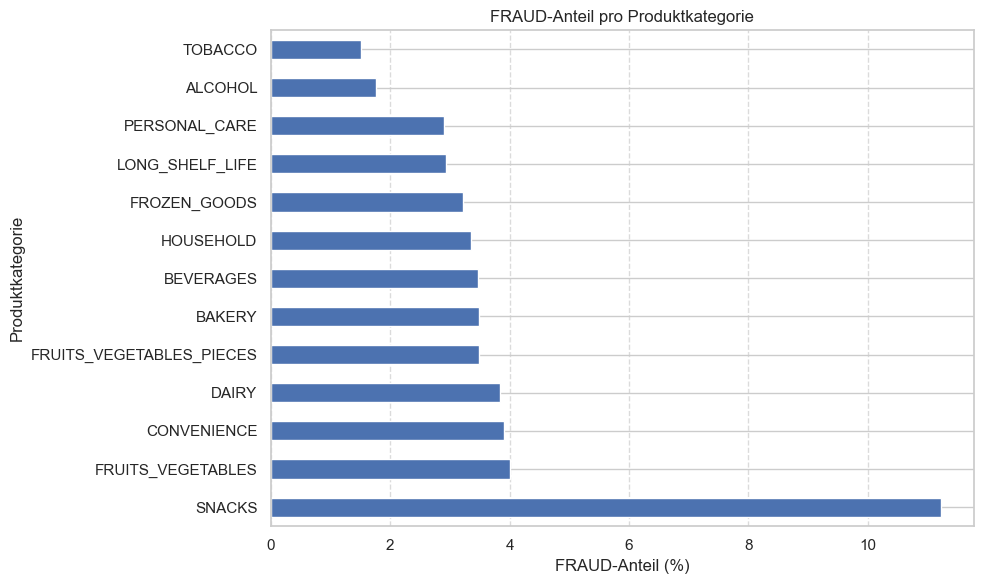

In [65]:
# Kreuztabelle mit Prozentanteilen je Kategorie
label_distribution = pd.crosstab(
    joined_tables['category'],
    joined_tables['label'],
    normalize='index'
) * 100

# Nur FRAUD-Anteil extrahieren
fraud_share = label_distribution['FRAUD'].sort_values(ascending=False)

# Plot
plt.figure(figsize=(10, 6))
fraud_share.plot(kind='barh')
plt.title('FRAUD-Anteil pro Produktkategorie')
plt.xlabel('FRAUD-Anteil (%)')
plt.ylabel('Produktkategorie')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [66]:
# Kontingenztabelle: absolute Häufigkeiten
contingency_table = pd.crosstab(joined_tables['category'], joined_tables['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(contingency_table)

# Ergebnisse anzeigen
print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)
print("\nErwartete Häufigkeiten unter H0:")
print(pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns))


Chi²-Statistik: 854.2847436567963
p-Wert: 3.742902704932478e-175
Freiheitsgrade: 12

Erwartete Häufigkeiten unter H0:
label                            FRAUD         NORMAL
category                                             
ALCOHOL                      93.254659    2576.745341
BAKERY                       73.241580    2023.758420
BEVERAGES                 15081.723193  416727.276807
CONVENIENCE                2243.735030   61997.264970
DAIRY                      4904.217097  135509.782903
FROZEN_GOODS               4781.588967  132121.411033
FRUITS_VEGETABLES           145.679843    4025.320157
FRUITS_VEGETABLES_PIECES  27102.283628  748870.716372
HOUSEHOLD                   226.256060    6251.743940
LONG_SHELF_LIFE            2418.823271   66835.176729
PERSONAL_CARE               541.365996   14958.634004
SNACKS                      122.383642    3381.616358
TOBACCO                      32.447033     896.552967


In [61]:
# Visualisierung
import matplotlib.pyplot as plt

fraud_rates = crosstab[1]  # Spalte für FRAUD
fraud_rates.sort_values(ascending=False).plot(kind='barh', figsize=(8, 6))
plt.xlabel('Anteil FRAUD')
plt.title('FRAUD-Anteil nach Produktkategorie')
plt.tight_layout()
plt.show()


KeyError: 1

In [69]:
# Kontingenztabelle (absolute Häufigkeiten)
contingency = pd.crosstab(joined_tables['category'], joined_tables['label'])

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


Chi² = 854.28, p-Wert = 0.0000


In [ ]:
# Auf Transaktionsebene

# Fraud-Rate je Kategorie mit sauberer Benennung
category_stats = joined_tables.groupby('category').agg(
    total=('label', 'count'),
    fraud_rate=('label', 'mean')
)

# Top 5 Fraud-Kategorien mit mind. 100 Vorkommen
top_fraud_categories = category_stats[category_stats['total'] >= 100] \
    .sort_values('fraud_rate', ascending=False) \
    .head(5).index

# Neue Spalte auf Zeilenebene: ist Top-Fraud-Kategorie?
joined_tables['is_top_fraud_category'] = joined_tables['category'].isin(top_fraud_categories).astype(int)

# Aggregation auf Transaktionsebene
trans_fraud_cat_flag = joined_tables.groupby('transaction_id')['is_top_fraud_category'].max().to_frame()

# Label ebenfalls auf Transaktionsebene
transactions_cat = joined_tables.groupby('transaction_id')['label'].first().to_frame()

# Merge
transactions_cat = transactions_cat.join(trans_fraud_cat_flag)

# Chi²-Test
from scipy.stats import chi2_contingency
ct_cat = pd.crosstab(transactions_cat['is_top_fraud_category'], transactions_cat['label'])
chi2, p, dof, expected = chi2_contingency(ct_cat)

# Ausgabe
print(ct_cat)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                       0     1
is_top_fraud_category              
0                       13912   336
1                      136780  4663
Chi² = 36.38, p-Wert = 0.0000


--> Besonders auffällig war die Kategorie "SNACKS", die mit einem FRAUD-Anteil von über 10 % deutlich aus dem Gesamtspektrum hervorsticht. Kategorien mit besonders niedriger FRAUD-Rate: TOBACCO: nur 1,5 % | ALCOHOL: 1,8 %.
Zur Untersuchung des **Zusammenhangs zwischen der Produktkategorie und dem Transaktionslabel** wurde ein Chi²-Test auf Unabhängigkeit durchgeführt. Wie sich zeigte, besteht ein statistisch hochsignifikanter Zusammenhang zwischen Produktkategorie und dem Label.
Dabei ist zu beachten, dass der Zusammenhang nicht auf einzelne Produktebene, sondern auf Transaktionsebene aggregiert interpretiert werden muss. Das bedeutet, dass das Label auf alle zugehörigen Produktzeilen (Transaction Lines) übertragen wurde; Alle Produkte einer Transaktion tragen also das gleiche Label. Häufig gekaufte Produktkategorien innerhalb betrügerischer Transaktionen beeinflussen das Ergebnis entsprechend stärker.
Daraus lässt sich schließen, dass 'category' ein nützliches Attribut für spätere Klassifikationsmodelle ist – z. B. durch Einbezug als kategorisches Feature oder durch Risikogewichtung.

### Analyse product_id vs label

In [70]:
# Fraud-Anteil je Produkt berechnen
product_fraud_stats = joined_tables.groupby('product_id')['label'].agg(['count', 'sum', 'mean']).rename(
    columns={'count': 'total_occurrences', 'sum': 'fraud_count', 'mean': 'fraud_rate'}
)

# Optional: Nur Produkte mit ausreichend Fällen analysieren
product_fraud_stats = product_fraud_stats[product_fraud_stats['total_occurrences'] >= 5]

# Nach Fraud-Rate sortieren
top_fraud_products = product_fraud_stats.sort_values('fraud_rate', ascending=False)


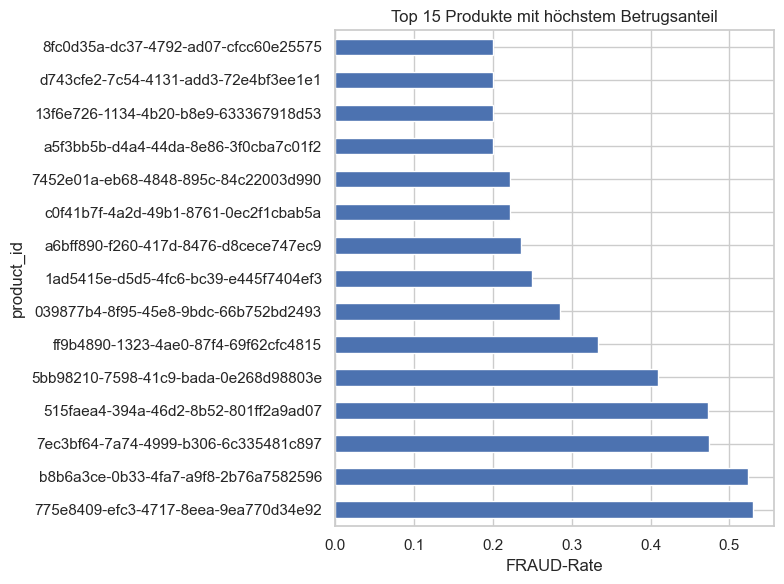

In [71]:
# Visualisierung

top_fraud_products.head(15)['fraud_rate'].plot(kind='barh', figsize=(8,6))
plt.xlabel('FRAUD-Rate')
plt.title('Top 15 Produkte mit höchstem Betrugsanteil')
plt.tight_layout()
plt.show()


In [72]:
# Schritt 1: Fraud-Rate je Produkt berechnen
product_stats = joined_tables.groupby('product_id')['label'].agg(['count', 'mean']).rename(
    columns={'count': 'total', 'mean': 'fraud_rate'}
)

# Nur Produkte mit mindestens 5 Vorkommen berücksichtigen
filtered_products = product_stats[product_stats['total'] >= 5]

# Top 10 Fraud-Produkte holen
top_n = 10
top_fraud_products = filtered_products.sort_values('fraud_rate', ascending=False).head(top_n).index

# Schritt 2: Neue Spalte: Produkt ist auffällig oder nicht
joined_tables['is_top_fraud_product'] = joined_tables['product_id'].isin(top_fraud_products).astype(int)


In [ ]:
# Chi²-Test
# Kontingenztabelle
ct = pd.crosstab(joined_tables['is_top_fraud_product'], joined_tables['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")

Chi² = 3549.18, p-Wert = 0.0000


In [75]:
# Logistische Regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Merkmale & Ziel
X = joined_tables[['is_top_fraud_product']]
y = joined_tables['label']

# Split & Modell
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

# Ergebnis
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
print("Modellkoeffizient:", model.coef_)


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    399044
           1       0.00      0.00      0.00     14442

    accuracy                           0.97    413486
   macro avg       0.48      0.50      0.49    413486
weighted avg       0.93      0.97      0.95    413486

Modellkoeffizient: [[3.1277071]]


c:\Users\sofie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sofie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\sofie\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [76]:
# Top-Fraud-Produkte (z. B. Top 10)
top_fraud_products = set(top_fraud_products)

# Transaktion enthält eines dieser Produkte
trans_fraud_flag = joined_tables[joined_tables['product_id'].isin(top_fraud_products)] \
    .groupby('transaction_id') \
    .size() \
    .to_frame(name='has_top_fraud_product') \
    .assign(has_top_fraud_product=1)

# Transaktions-Daten mit Label
transactions = joined_tables.groupby('transaction_id')['label'].first().to_frame()

# Merge
transactions = transactions.merge(trans_fraud_flag, how='left', left_index=True, right_index=True)
transactions['has_top_fraud_product'] = transactions['has_top_fraud_product'].fillna(0).astype(int)


In [79]:
# Kontingenztabelle
ct = pd.crosstab(transactions['has_top_fraud_product'], transactions['label'])
print(ct)
chi2, p, dof, expected = chi2_contingency(ct)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                       0     1
has_top_fraud_product              
0                      150342  4697
1                         350   302
Chi² = 3901.18, p-Wert = 0.0000


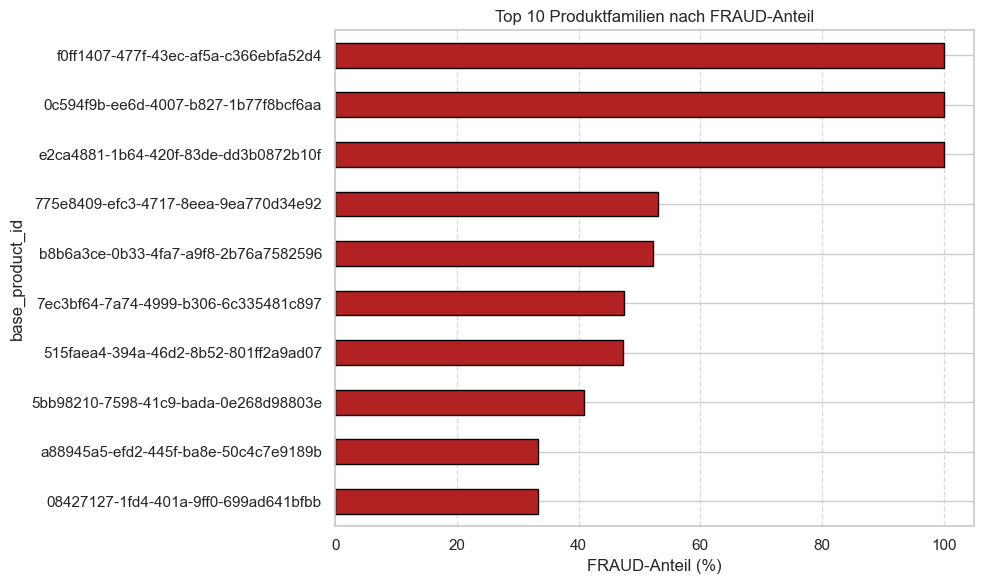

In [67]:
# Schritt 1: Kontingenztabelle mit Prozenten je base_product_id
label_dist = pd.crosstab(
    joined_tables['base_product_id'],
    joined_tables['label'],
    normalize='index'
) * 100

# Schritt 2: FRAUD-Anteile extrahieren
fraud_top10 = label_dist['FRAUD'].sort_values(ascending=False).head(10)

# Schritt3: plotten
plt.figure(figsize=(10, 6))
fraud_top10.plot(kind='barh', color='firebrick', edgecolor='black')
plt.title('Top 10 Produktfamilien nach FRAUD-Anteil')
plt.xlabel('FRAUD-Anteil (%)')
plt.ylabel('base_product_id')
plt.gca().invert_yaxis()  # Höchster Wert oben
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [68]:
# Kombination aus Fraud-Anteil und Transaktionsanzahl
fraud_counts = joined_tables.groupby('base_product_id')['label'].value_counts(normalize=False).unstack(fill_value=0)
fraud_counts['total'] = fraud_counts.sum(axis=1)
fraud_counts['fraud_rate'] = (fraud_counts['FRAUD'] / fraud_counts['total']) * 100

# Nur Produkte mit z. B. mindestens 20 Transaktionen anzeigen
top10_filtered = fraud_counts[fraud_counts['total'] >= 20].sort_values(by='fraud_rate', ascending=False).head(10)


In [69]:
# 1. Berechnung der Fraud-Anteile und Fallzahlen
fraud_counts = joined_tables.groupby('base_product_id')['label'].value_counts().unstack(fill_value=0)
fraud_counts['total'] = fraud_counts.sum(axis=1)
fraud_counts['fraud_rate'] = (fraud_counts['FRAUD'] / fraud_counts['total']) * 100

# 2. Filter: nur Produktfamilien mit ausreichend Transaktionen (z. B. ≥ 20)
filtered = fraud_counts[fraud_counts['total'] >= 20]

# 3. Top 10 mit höchstem FRAUD-Anteil
top10_filtered = filtered.sort_values(by='fraud_rate', ascending=False).head(10)


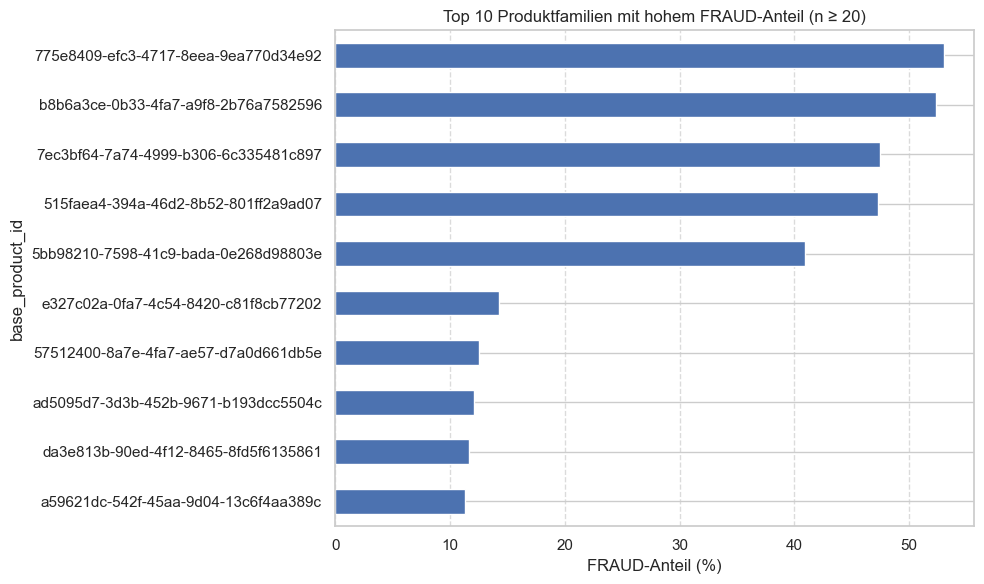

In [71]:
plt.figure(figsize=(10, 6))
top10_filtered['fraud_rate'].plot(kind='barh')
plt.title('Top 10 Produktfamilien mit hohem FRAUD-Anteil (n ≥ 20)')
plt.xlabel('FRAUD-Anteil (%)')
plt.ylabel('base_product_id')
plt.gca().invert_yaxis()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


--> Um statistisch stabile Aussagen über potenziell betrugsanfällige Produktfamilien zu treffen, wurden alle base_product_ids mit weniger als 20 Transaktionen aus der Analyse ausgeschlossen.
Die resultierende Top-10-Liste zeigt Produktfamilien mit FRAUD-Anteilen von über 40 %, was deutlich über dem Gesamtdurchschnitt liegt. Diese Produkte treten somit **unverhältnismäßig häufig in betrügerischen Transaktionen** auf.
Diese Erkenntnisse lassen sich zum Beispiel für regelbasierte Frühwarnsysteme, risikogewichtete Feature-Konstruktion, filialspezifische Schulungsmaßnahmen oder Prüfalgorithmen nutzen.
Die Kategorisierung nach 'base_product_id' ist damit ein relevanter Prädiktor für Betrugsverdacht in der Modellierung.

### Analyse age_restricted

In [82]:
# Neue Spalte auf Transaktionsebene: enthält altersbeschränktes Produkt?
trans_age_restricted = joined_tables.groupby('transaction_id')['age_restricted'].max().to_frame()

# Label auf Transaktionsebene
transactions_age = joined_tables.groupby('transaction_id')['label'].first().to_frame()

# Merge
transactions_age = transactions_age.join(trans_age_restricted)
transactions_age['age_restricted'] = transactions_age['age_restricted'].fillna(0).astype(int)


In [83]:
# Kontingenztabelle
ct_age = pd.crosstab(transactions_age['age_restricted'], transactions_age['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(ct_age)

# Ausgabe
print(ct_age)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                0     1
age_restricted              
0               147326  4942
1                 3366    57
Chi² = 26.40, p-Wert = 0.0000


In [72]:
# Prozentuale Verteilung (jeweils auf 'true' und 'false' bezogen)
label_dist_age = pd.crosstab(
    joined_tables['age_restricted'],
    joined_tables['label'],
    normalize='index'
) * 100

print(label_dist_age.round(2))


label           FRAUD  NORMAL
age_restricted               
False            3.50   96.50
True             1.69   98.31


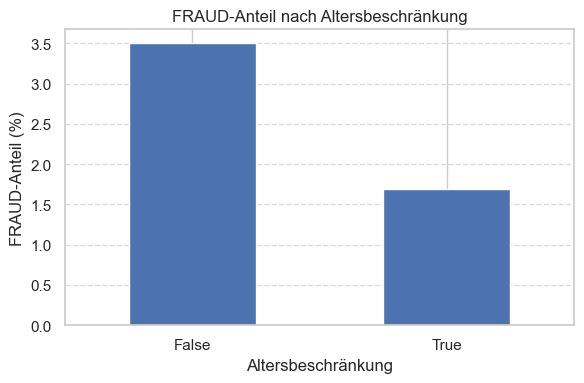

In [76]:
# Nur FRAUD-Anteil extrahieren
fraud_rate_age = label_dist_age['FRAUD'].sort_values(ascending=False)

# Plot
plt.figure(figsize=(6, 4))
fraud_rate_age.plot(kind='bar')
plt.title('FRAUD-Anteil nach Altersbeschränkung')
plt.ylabel('FRAUD-Anteil (%)')
plt.xlabel('Altersbeschränkung')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [75]:
# Absolute Häufigkeiten
contingency_age = pd.crosstab(joined_tables['age_restricted'], joined_tables['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(contingency_age)

print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)


Chi²-Statistik: 34.05160933522221
p-Wert: 5.366950113655265e-09
Freiheitsgrade: 1


Die Altersbeschränkung zeigt einen **signifikanten Zusammenhang** mit der Fehlerbehaftung einer Transaktion.
Während Produkte ohne Altersbeschränkung in 3.5 % der Fälle Teil einer betrügerischen Transaktion sind, liegt der Fraud-Anteil bei altersbeschränkten Produkten bei nur 1.69 %. Ein Chi²-Test bestätigt die Signifikanz dieses Zusammenhangs.
Es kann daher davon ausgegangen werden, dass altersbeschränkte Produkte seltener in betrügerischen Transaktionen auftreten. Dies könnte auf zusätzliche Prüfmechanismen an der Kasse (z. B. manuelle Altersprüfung).
Das Attribut 'age_restricted' kann somit als potenziell nützliches Prädiktor-Feature für Klassifikationsmodelle herangezogen werden.

### Analyse 'sold_by_weight'

In [84]:
# Für jede Transaktion prüfen: gab es ein gewichtsverkauftes Produkt?
trans_weight = joined_tables.groupby('transaction_id')['sold_by_weight'].max().to_frame()

# Label ergänzen
transactions_weight = joined_tables.groupby('transaction_id')['label'].first().to_frame()
transactions_weight = transactions_weight.join(trans_weight)

# Datentyp korrigieren (falls NaN)
transactions_weight['sold_by_weight'] = transactions_weight['sold_by_weight'].fillna(0).astype(int)


In [85]:
# Kontingenztabelle
ct_weight = pd.crosstab(transactions_weight['sold_by_weight'], transactions_weight['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(ct_weight)

# Ausgabe
print(ct_weight)
print(f"Chi² = {chi2:.2f}, p-Wert = {p:.4f}")


label                0     1
sold_by_weight              
0               147161  4858
1                 3531   141
Chi² = 4.58, p-Wert = 0.0323


In [77]:
label_dist_weight = pd.crosstab(
    joined_tables['sold_by_weight'],
    joined_tables['label'],
    normalize='index'
) * 100

print(label_dist_weight.round(2))

label           FRAUD  NORMAL
sold_by_weight               
False            3.49   96.51
True             4.00   96.00


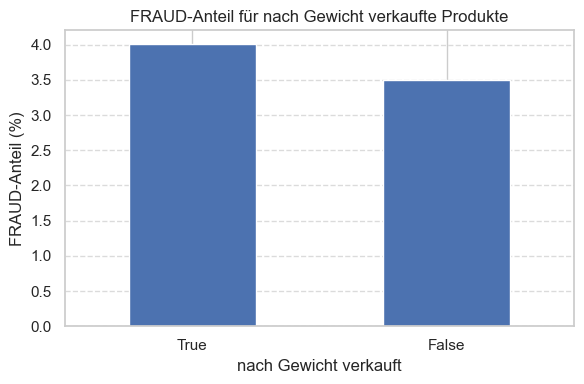

In [79]:
fraud_rate_weight = label_dist_weight['FRAUD'].sort_values(ascending=False)

plt.figure(figsize=(6, 4))
fraud_rate_weight.plot(kind='bar')
plt.title('FRAUD-Anteil für nach Gewicht verkaufte Produkte')
plt.ylabel('FRAUD-Anteil (%)')
plt.xlabel('nach Gewicht verkauft')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [80]:
contingency_weight = pd.crosstab(joined_tables['sold_by_weight'], joined_tables['label'])

chi2, p, dof, expected = chi2_contingency(contingency_weight)

print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)


Chi²-Statistik: 3.091041924803183
p-Wert: 0.07872438469800992
Freiheitsgrade: 1


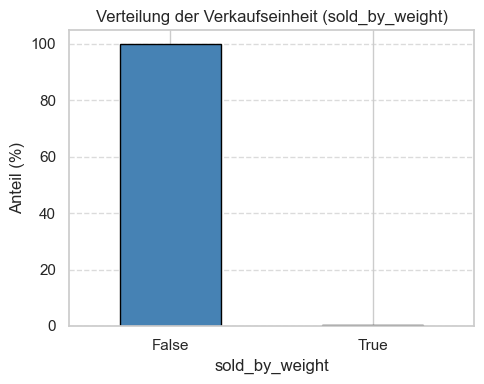

sold_by_weight
False    99.75
True      0.25
Name: proportion, dtype: float64


In [82]:
# Prozentuale Verteilung der Werte in 'sold_by_weight'
sold_by_weight_share = joined_tables['sold_by_weight'].value_counts(normalize=True) * 100

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
sold_by_weight_share.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title('Verteilung der Verkaufseinheit (sold_by_weight)')
plt.ylabel('Anteil (%)')
plt.xlabel('sold_by_weight')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Optional: Ausgabe in Textform
print(sold_by_weight_share.round(2))

Die Analyse des Attributs 'sold_by_weight' (Unterscheidung zwischen nach Gewicht und nach Stückzahl verkauften Produkten) zeigt einen leicht höheren Fraud-Anteil bei gewichtsverkauften Produkten (4.00 %) im Vergleich zu stückverkauften (3.49 %). Ein Chi²-Test auf Unabhängigkeit zeigte **keinen statistisch signifikanten Zusammenhang** zwischen Verkaufseinheit und Betrugsstatus.
Das Attribut 'sold_by_weight' ist daher nicht als starker Prädiktor für fehlerhafte Transaktionen einzuschätzen, sollte jedoch ggf. im Zusammenspiel mit anderen Merkmalen weiter betrachtet werden.

### Analyse 'price'

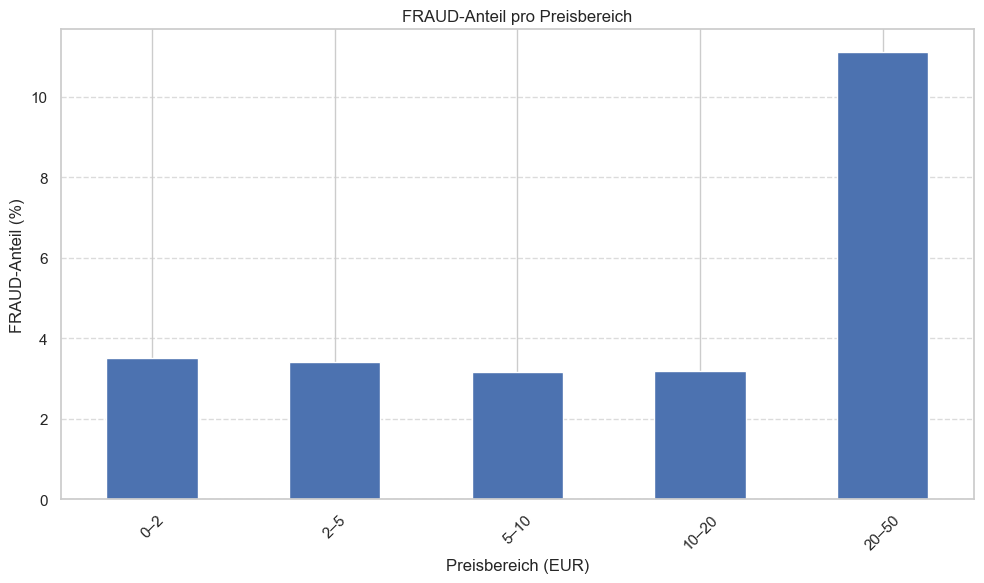

In [ ]:
# Preis-Binning
bins = [0, 2, 5, 10, 20, 50, 100, 200, 300, 400, 500, 600]
labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]
joined_tables['price_bin'] = pd.cut(joined_tables['price'], bins=bins, labels=labels, right=False)

# Prozentualer FRAUD-Anteil je Preisbin
fraud_rate = pd.crosstab(
    joined_tables['price_bin'],
    joined_tables['label'],
    normalize='index'
)['FRAUD'] * 100

# Plot
plt.figure(figsize=(10, 6))
fraud_rate.plot(kind='bar')
plt.title('FRAUD-Anteil pro Preisbereich')
plt.xlabel('Preisbereich (EUR)')
plt.ylabel('FRAUD-Anteil (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [85]:
# Anzahl Transaktionen pro Preisbereich
bin_counts = joined_tables['price_bin'].value_counts().sort_index()
print(bin_counts)

price_bin
0–2        1396256
2–5         237351
5–10         19005
10–20         1322
20–50            9
50–100           0
100–200          0
200–300          0
300–400          0
400–500          0
500–600          0
Name: count, dtype: int64


In [86]:
# Kontingenztabelle: absolute Häufigkeiten von Label je Preisbereich
price_label_counts = pd.crosstab(joined_tables['price_bin'], joined_tables['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(price_label_counts)

# Ergebnisse anzeigen
print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)

# Erwartete Häufigkeiten anzeigen (unter Annahme: kein Zusammenhang)
expected_df = pd.DataFrame(expected, index=price_label_counts.index, columns=price_label_counts.columns)
print("\nErwartete Häufigkeiten unter H0:")
print(expected_df.round(2))


Chi²-Statistik: 13.595705406947587
p-Wert: 0.008703723972365518
Freiheitsgrade: 4

Erwartete Häufigkeiten unter H0:
label         FRAUD      NORMAL
price_bin                      
0–2        48766.81  1347489.19
2–5         8289.92   229061.08
5–10         663.78    18341.22
10–20         46.17     1275.83
20–50          0.31        8.69


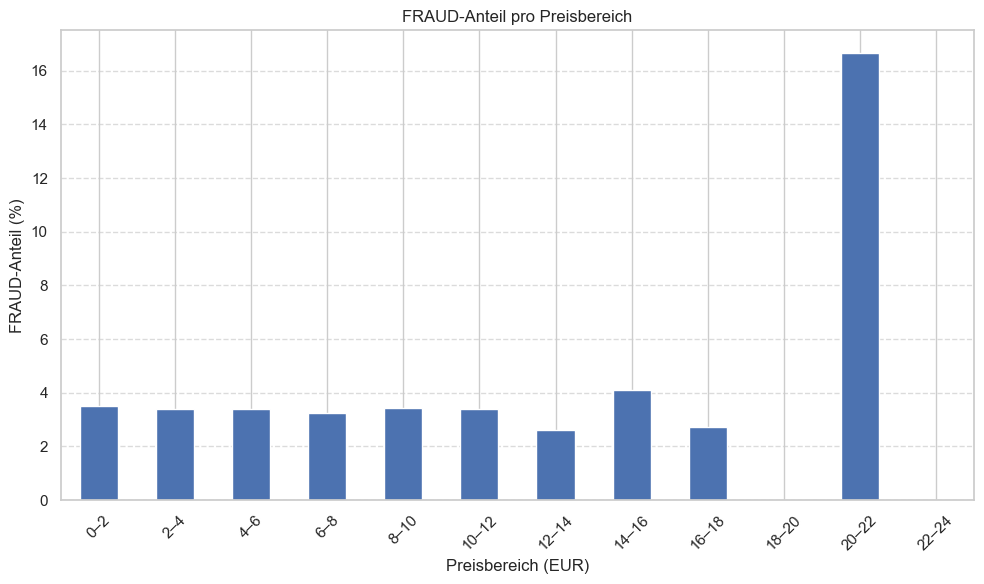

In [87]:
# Preis-Binning
bins = [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 25, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50]
labels = [f"{bins[i]}–{bins[i+1]}" for i in range(len(bins)-1)]
joined_tables['price_bin'] = pd.cut(joined_tables['price'], bins=bins, labels=labels, right=False)

# Prozentualer FRAUD-Anteil je Preisbin
fraud_rate = pd.crosstab(
    joined_tables['price_bin'],
    joined_tables['label'],
    normalize='index'
)['FRAUD'] * 100

# Plot
plt.figure(figsize=(10, 6))
fraud_rate.plot(kind='bar')
plt.title('FRAUD-Anteil pro Preisbereich')
plt.xlabel('Preisbereich (EUR)')
plt.ylabel('FRAUD-Anteil (%)')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [88]:
# Anzahl Transaktionen pro Preisbereich
bin_counts = joined_tables['price_bin'].value_counts().sort_index()
print(bin_counts)

price_bin
0–2      1396256
2–4       214594
4–6        33617
6–8         6191
8–10        1954
10–12        794
12–14        308
14–16        122
16–18         73
18–20         25
20–22          6
22–24          3
24–25          0
25–26          0
26–28          0
28–30          0
30–32          0
32–34          0
34–36          0
36–38          0
38–40          0
40–42          0
42–44          0
44–46          0
46–48          0
48–50          0
Name: count, dtype: int64


In [90]:
# Kontingenztabelle: absolute Häufigkeiten von Label je Preisbereich
price_label_counts = pd.crosstab(joined_tables['price_bin'], joined_tables['label'])

# Chi²-Test
chi2, p, dof, expected = chi2_contingency(price_label_counts)

# Ergebnisse anzeigen
print("Chi²-Statistik:", chi2)
print("p-Wert:", p)
print("Freiheitsgrade:", dof)

# Erwartete Häufigkeiten anzeigen (unter Annahme: kein Zusammenhang)
expected_df = pd.DataFrame(expected, index=price_label_counts.index, columns=price_label_counts.columns)
print("\nErwartete Häufigkeiten unter H0:")
print(expected_df.round(2))


Chi²-Statistik: 13.784678319337129
p-Wert: 0.24513794686389279
Freiheitsgrade: 11

Erwartete Häufigkeiten unter H0:
label         FRAUD      NORMAL
price_bin                      
0–2        48766.81  1347489.19
2–4         7495.09   207098.91
4–6         1174.14    32442.86
6–8          216.23     5974.77
8–10          68.25     1885.75
10–12         27.73      766.27
12–14         10.76      297.24
14–16          4.26      117.74
16–18          2.55       70.45
18–20          0.87       24.13
20–22          0.21        5.79
22–24          0.10        2.90


--> Zur Überprüfung eines möglichen Zusammenhangs zwischen dem Produktpreis und dem Fraud-Status (label) wurde die Preisspalte mithilfe von festen Bins kategorisiert. Für eine feine Betrachtung möglicher Preisgrenzen wurde die 'price'-Spalte in 2-€-Bänder unterteilt. Die Analyse des Fraud-Anteils pro Preisbereich zeigte einen auffällig hohen Wert im Intervall 20–22 € (> 16 %), allerdings bei nur 6 Transaktionen.
Ein Chi²-Test zur Prüfung eines Zusammenhangs zwischen Preisbereich und Label ergab, dass mit den gewählten Intervallen **kein belastbarer Zusammenhang zwischen Preisniveau und Frauds** festgestellt werden konnte. Die Aussagekraft wird insbesondere durch die sehr geringe Fallzahl in den höheren Preisbereichen eingeschränkt.
Für die weitere Modellierung empfiehlt sich entweder eine dynamische Binning-Strategie (z. B. Quantile) oder eine Feature-Transformation wie log(price).

Popularity prüfen

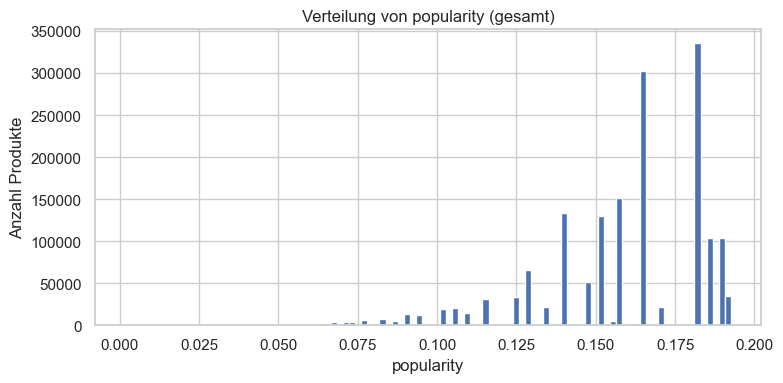

In [92]:
plt.figure(figsize=(8, 4))
joined_tables['popularity'].hist(bins=100)
plt.title('Verteilung von popularity (gesamt)')
plt.xlabel('popularity')
plt.ylabel('Anzahl Produkte')
plt.grid(True)
plt.tight_layout()
plt.show()


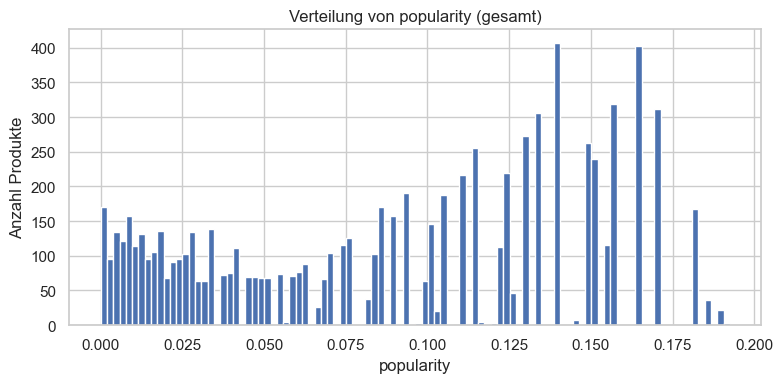

In [95]:
plt.figure(figsize=(8, 4))
products['popularity'].hist(bins=100)
plt.title('Verteilung von popularity (gesamt)')
plt.xlabel('popularity')
plt.ylabel('Anzahl Produkte')
plt.grid(True)
plt.tight_layout()
plt.show()


In [93]:
# Durchschnittliche Popularität je Kategorie
pop_by_cat = joined_tables.groupby('category')['popularity'].mean().sort_values()
print(pop_by_cat.round(2))

category
FRUITS_VEGETABLES           0.05
TOBACCO                     0.06
HOUSEHOLD                   0.12
FROZEN_GOODS                0.12
ALCOHOL                     0.12
CONVENIENCE                 0.13
PERSONAL_CARE               0.13
DAIRY                       0.14
SNACKS                      0.15
LONG_SHELF_LIFE             0.16
BAKERY                      0.16
FRUITS_VEGETABLES_PIECES    0.16
BEVERAGES                   0.18
Name: popularity, dtype: float64


In [96]:
# Durchschnittliche Popularität je Kategorie
pop_by_cat = products.groupby('category')['popularity'].mean().sort_values()
print(pop_by_cat.round(2))

category
LIMITED_TIME_OFFERS         0.01
FRUITS_VEGETABLES           0.03
TOBACCO                     0.04
ALCOHOL                     0.07
FROZEN_GOODS                0.09
HOUSEHOLD                   0.10
CONVENIENCE                 0.10
PERSONAL_CARE               0.11
DAIRY                       0.12
SNACKS                      0.13
LONG_SHELF_LIFE             0.15
BAKERY                      0.15
FRUITS_VEGETABLES_PIECES    0.16
BEVERAGES                   0.17
Name: popularity, dtype: float64


In [94]:
# Extremwerte anzeigen
print(joined_tables['popularity'].describe())

# Produkte mit extrem hoher Popularität
print(joined_tables[joined_tables['popularity'] > 10].sort_values(by='popularity', ascending=False).head())

# Produkte mit popularity = 0 oder NaN
print(joined_tables[joined_tables['popularity'] == 0])
print(joined_tables['popularity'].isna().sum())

count    1.653943e+06
mean     1.579308e-01
std      2.749834e-02
min      1.680016e-03
25%      1.471176e-01
50%      1.640740e-01
75%      1.813298e-01
max      1.925426e-01
Name: popularity, dtype: float64
Empty DataFrame
Columns: [transaction_id, label, id, product_id, timestamp, pieces_or_weight, sales_price, was_voided, camera_product_similar, camera_certainty, base_product_id, category, price, popularity, valid_from, valid_to, sold_by_weight, weight, age_restricted, price_bin]
Index: []
Empty DataFrame
Columns: [transaction_id, label, id, product_id, timestamp, pieces_or_weight, sales_price, was_voided, camera_product_similar, camera_certainty, base_product_id, category, price, popularity, valid_from, valid_to, sold_by_weight, weight, age_restricted, price_bin]
Index: []
0


In [97]:
# Extremwerte anzeigen
print(products['popularity'].describe())

# Produkte mit extrem hoher Popularität
print(products[products['popularity'] > 10].sort_values(by='popularity', ascending=False).head())

# Produkte mit popularity = 0 oder NaN
print(products[products['popularity'] == 0])
print(products['popularity'].isna().sum())

count    8.120000e+03
mean     9.211875e-02
std      5.608844e-02
min      1.254813e-52
25%      3.660985e-02
50%      1.015262e-01
75%      1.398146e-01
max      1.925426e-01
Name: popularity, dtype: float64
Empty DataFrame
Columns: [product_id, base_product_id, category, price, popularity, valid_from, valid_to, sold_by_weight, weight, age_restricted]
Index: []
Empty DataFrame
Columns: [product_id, base_product_id, category, price, popularity, valid_from, valid_to, sold_by_weight, weight, age_restricted]
Index: []
0


--> Die Analyse der popularity-Werte auf Produkt- und Transaktionsebene zeigt, dass das Attribut nicht skaliert ist wie ein klassisches Wahrscheinlichkeitsverhältnis, sondern eher als normalisiertes Popularitätsmaß innerhalb einer Kategorie interpretiert werden muss.
Der Gesamtmittelwert in products liegt bei ~0.092, mit einer extrem breiten Spannweite bis hin zu nahezu Null – was auf mögliche technische Artefakte oder fehlerhafte Crawling-Werte hindeutet.

Während joined_tables durch die Transaktionshäufigkeit dominiert wird und einen Werteschwerpunkt bei 0.15–0.18 aufweist, ist products['popularity'] wesentlich uneinheitlicher verteilt.
Dies weist auf inhaltliche Inkonsistenz und mangelnde Erklärbarkeit durch die ursprüngliche Beschreibung hin. Für Modellierungszwecke ist daher Vorsicht geboten – eine Transformation oder eine Kombination mit tatsächlichen Verkaufszahlen wäre sinnvoll.